
# Loading Data

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00


In [26]:
import numpy as np
import h5py

In [ ]:
M_star = f['Subhalo/SubhaloMassType'][:,4]*1e10
pos  = f['Subhalo/SubhaloPos'][:]/1e3
vel = f['Subhalo/SubhaloVel'][:]
met = f['Subhalo/SubhaloStarMetallicity'][:]

In [28]:
def load_and_filter_data(file, mass_threshold=2e8):
    with h5py.File(file, 'r') as f:
        positions = f['Subhalo/SubhaloPos'][:]/1e3  # Convert to Mpc/h
        vel = f['Subhalo/SubhaloVel'][:]
        metallicities = f['Subhalo/SubhaloStarMetallicity'][:]
        masses = f['Subhalo/SubhaloMassType'][:,4]*1e10  # Stellar mass
        radii = f['Subhalo/SubhaloHalfmassRadType'][:,4]/1e3
        omega_m = f['Header'].attrs['Omega0']
    
    # Filter galaxies based on the stellar mass threshold
    mask = masses > mass_threshold
    positions = positions[mask]
    vel = vel[mask]
    metallicities = metallicities[mask]
    masses = masses[mask]
    radii = radii[mask]
    
    return positions, vel, metallicities, masses, radii, omega_m

In [29]:
def apply_periodic_boundary_conditions(positions, box_size):
    # Wrap positions to the box size
    positions = positions % box_size
    return positions

In [30]:
def minimum_image_distance(pos1, pos2, box_size):
    # Calculate the minimum image distance between two points
    delta = np.abs(pos1 - pos2)
    delta = np.where(delta > 0.5 * box_size, box_size - delta, delta)
    return np.sqrt((delta ** 2).sum(axis=-1))

In [31]:
from scipy.spatial import KDTree

def distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def create_edges_knn(points, k=6):
    edges = []
    edge_value = []

    # Create a KDTree for efficient nearest neighbor search
    point_tree = KDTree(points)

    for i in range(len(points)):
        # Query the k nearest neighbors for each point
        _, neighbors = point_tree.query(points[i], k=k+1)

        for j in neighbors[1:]:  # Skip the first neighbor because it's the point itself
            # Add an edge between the point and its neighbor
            edges.append([i, j])

            # Compute the distance between the points as the edge value
            edge_value.append(distance(points[i], points[j]))

    return [edges, edge_value]

In [32]:
from tqdm import tqdm
def min_distance(positions, box_size = 25):
    min_distance = np.inf
    max_distance = 0

    # Iterate over all pairs of galaxies
    for i in range(len(positions)):
        for j in range(i + 1, len(positions)):
            dist = minimum_image_distance(positions[i], positions[j], box_size)
            if dist < min_distance:
                min_distance = dist
            if dist > max_distance:
                max_distance = dist

    # Print the results
    print(f"Minimum distance: {min_distance} Mpc/h")
    print(f"Maximum distance: {max_distance} Mpc/h")

In [33]:
def minimum_image_distance_vectorized(positions, box_size = 25):
    num_galaxies = positions.shape[0]

    # Compute pairwise differences in each dimension
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]

    # Apply periodic boundary conditions
    diff = np.abs(diff)
    diff = np.where(diff > 0.5 * box_size, box_size - diff, diff)

    # Compute the Euclidean distance
    dist = np.sqrt(np.sum(diff ** 2, axis=-1))

    return dist

In [34]:
from tqdm import tqdm
from scipy.spatial import cKDTree
def create_edges_knn_pbc(points, box_size = 25, k=6):
    tree = KDTree(points, boxsize=box_size)

    edges = []
    edge_values = []
    '''
    distances = minimum_image_distance_vectorized(points, box_size)
    # Mask the diagonal (self-distances which are zero)
    np.fill_diagonal(distances, np.inf)
    # Get the minimum and maximum distances
    min_distance = np.min(distances)
    max_distance = np.max(np.triu(distances, k=1))
    print(min_distance, max_distance)
    '''

    min_distance = np.inf
    max_distance = 0
    large_distance_count = 0

    for i in range(len(points)):
        distances, neighbors = tree.query(points[i], k=k+1)
        for j, tree_dist in zip(neighbors[1:], distances[1:]):
            if j != i and j < len(points):
                actual_distance = minimum_image_distance(points[i], points[j], box_size)
                edges.append([i, j])
                edge_values.append(actual_distance)
                min_distance = min(min_distance, actual_distance)
                max_distance = max(max_distance, actual_distance)
    return np.array(edges), np.array(edge_values)


In [64]:
def create_points(positions, masses, vel, met, radii):
    point_features = []
    for i, pos in enumerate(positions):
        point_features.append(list(pos) + [masses[i]] + [met[i]] + [radii[i]])
    return point_features

In [65]:
from torch_geometric.data import Data
import torch
def create_graph(file_path, k_val=6):
    positions, velocity, metallicities, masses, radii, omega_m = load_and_filter_data(file_path)
    edges, edge_values = create_edges_knn_pbc(positions, 25, k_val)
    point_values = create_points(positions, masses, velocity, metallicities, radii)

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    point_values = torch.tensor(point_values, dtype=torch.float)
    edge_value = torch.tensor(edge_values, dtype=torch.float)

    return [point_values, edge_index, edge_value, omega_m]

In [66]:
def turn_data(graph):
    graph_data = Data(x=graph[0], edge_index=graph[1], edge_attr=graph[2], y = graph[3])
    return graph_data

In [67]:
import torch
torch.cuda.is_available()

True

In [68]:
import torch_geometric.transforms as T
def create_data(file_path, k_val=6):
    graph = create_graph(file_path, k_val)
    data = turn_data(graph)
    data = T.ToUndirected()(data)
    #data = T.NormalizeFeatures()(data)
    return data

In [69]:
def calculate_normalization_params(data_list):
    # Concatenate all node features and edge attributes
    all_x = torch.cat([data.x for data in data_list], dim=0)
    all_edge_attr = torch.cat([data.edge_attr for data in data_list], dim=0)

    # Calculate mean and std for node features and edge attributes
    x_mean, x_std = all_x.mean(dim=0), all_x.std(dim=0)
    edge_attr_mean, edge_attr_std = all_edge_attr.mean(dim=0), all_edge_attr.std(dim=0)

    return (x_mean, x_std), (edge_attr_mean, edge_attr_std)

def normalize_dataset(data_list, x_params, edge_attr_params):
    x_mean, x_std = x_params
    edge_attr_mean, edge_attr_std = edge_attr_params

    normalized_data_list = []
    for data in data_list:
        normalized_x = (data.x - x_mean) / (x_std + 1e-8)
        normalized_edge_attr = (data.edge_attr - edge_attr_mean) / (edge_attr_std + 1e-8)

        # Create a new Data object with normalized features and original y value
        normalized_data = Data(x=normalized_x,
                               edge_index=data.edge_index,
                               edge_attr=normalized_edge_attr,
                               y=data.y)  # Preserve the original y value

        normalized_data_list.append(normalized_data)

    return normalized_data_list

In [75]:
import torch
import os
from torch.utils.data import random_split
from torch_geometric.data import DataLoader
import h5py
directory = '/scratch/gpfs/hk4638/FinalData/NewData'
def load_all_graphs(directory, k_val=10, box_size=25):
    file_list = os.listdir(directory)
    data_list = []
    for file_name in tqdm(file_list):
        file_path = os.path.join(directory, file_name)
        graph_data = create_data(file_path, k_val)
        data_list.append(graph_data)
    return data_list

# Load all graphs
data_list = load_all_graphs(directory)

# Calculate normalization parameters based on all graphs
x_params, edge_attr_params = calculate_normalization_params(data_list)

# Normalize the dataset using the calculated parameters
normalized_data_list = normalize_dataset(data_list, x_params, edge_attr_params)

import torch
import numpy as np

def numpy_to_torch_float(data):
    if isinstance(data, np.ndarray):
        return torch.from_numpy(data).float()
    elif isinstance(data, (np.float64, np.float32)):
        return torch.tensor(data, dtype=torch.float32)
    elif isinstance(data, torch.Tensor):
        return data.float()
    else:
        return data
        
def ensure_torch_float32(data):
    data.x = numpy_to_torch_float(data.x)
    data.edge_attr = numpy_to_torch_float(data.edge_attr)
    if hasattr(data, 'y'):
        data.y = numpy_to_torch_float(data.y)
    return data
    
normalized_data_list = [ensure_torch_float32(data) for data in normalized_data_list]

# Calculate the lengths for the 70-15-15 split
total_len = len(normalized_data_list)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len  # Ensures all data is used

# Perform the split
train_data, val_data, test_data = random_split(normalized_data_list, [train_len, val_len, test_len])

# Create DataLoaders for each split
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 1000/1000 [02:28<00:00,  6.74it/s]


# Heterogenous 

In [21]:
import numpy as np
import h5py
import torch
from torch_geometric.data import HeteroData
from scipy.spatial import cKDTree
from tqdm import tqdm

def load_and_filter_data(file, mass_threshold=2e8):
    with h5py.File(file, 'r') as f:
        positions = f['Subhalo/SubhaloPos'][:]/1e3  # Convert to Mpc/h
        metallicities = f['Subhalo/SubhaloStarMetallicity'][:]
        masses = f['Subhalo/SubhaloMassType'][:,4]*1e10  # Stellar mass
        omega_m = f['Header'].attrs['Omega0']
    # Filter galaxies based on the stellar mass threshold
    mask = masses > mass_threshold
    return positions[mask], metallicities[mask], masses[mask], omega_m

def split_galaxies(positions, masses, metallicities, split_ratios):
    total_galaxies = len(positions)
    indices = np.random.permutation(total_galaxies)
    split_points = [int(ratio * total_galaxies) for ratio in np.cumsum(split_ratios)]
    
    a_indices = indices[:split_points[0]]
    b_indices = indices[split_points[0]:split_points[1]]
    c_indices = indices[split_points[1]:]
    
    return {
        'A': (positions[a_indices], masses[a_indices], metallicities[a_indices]),
        'B': (positions[b_indices], masses[b_indices], metallicities[b_indices]),
        'C': (positions[c_indices], masses[c_indices], metallicities[c_indices])
    }

def minimum_image_distance(pos1, pos2, box_size):
    delta = np.abs(pos1 - pos2)
    delta = np.where(delta > 0.5 * box_size, box_size - delta, delta)
    return np.sqrt((delta ** 2).sum(axis=-1))

def create_edges_hetero(node_data, box_size=25, k=6):
    all_positions = np.concatenate([node_data[t][0] for t in ['A', 'B', 'C']])
    tree = cKDTree(all_positions, boxsize=box_size)
    
    edge_dict = {}
    node_types = ['A', 'B', 'C']
    start_idx = {'A': 0, 'B': len(node_data['A'][0]), 'C': len(node_data['A'][0]) + len(node_data['B'][0])}
    
    for src_type in node_types:
        src_positions = node_data[src_type][0]
        for dst_type in node_types:
            dst_positions = node_data[dst_type][0]
            edges = []
            edge_attrs = []
            
            for i, pos in enumerate(src_positions):
                distances, neighbors = tree.query(pos, k=k+1)
                for j, dist in zip(neighbors[1:], distances[1:]):
                    if start_idx[dst_type] <= j < start_idx[dst_type] + len(dst_positions):
                        edges.append([i, j - start_idx[dst_type]])
                        if src_type != 'B' and dst_type != 'B':
                            actual_distance = minimum_image_distance(pos, all_positions[j], box_size)
                            edge_attrs.append([actual_distance])
                        else:
                            edge_attrs.append([0.0])  # Placeholder for B connections
            
            if edges:
                edge_dict[(src_type, 'to', dst_type)] = (np.array(edges).T, np.array(edge_attrs))
    
    return edge_dict

def create_heterogeneous_graph(file_path, split_ratios, k_val=6):
    positions, metallicities, masses, omega_m = load_and_filter_data(file_path)
    node_data = split_galaxies(positions, masses, metallicities, split_ratios)
    edge_dict = create_edges_hetero(node_data, k=k_val)
    
    data = HeteroData()
    
    # Add node features
    data['A'].x = torch.tensor(np.column_stack(node_data['A'][0:1]), dtype=torch.float) # only position for A
    data['B'].x = torch.tensor(np.column_stack(node_data['B'][1:]), dtype=torch.float)  # Exclude positions for B
    data['C'].x = torch.tensor(np.column_stack(node_data['C']), dtype=torch.float)
    
    # Add edges
    for edge_type, (edge_index, edge_attr) in edge_dict.items():
        data[edge_type].edge_index = torch.tensor(edge_index, dtype=torch.long)
        if edge_type[0] != 'B' and edge_type[2] != 'B':
            data[edge_type].edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    # Add global target
    data.y = torch.tensor([omega_m], dtype=torch.float)
    
    return data

def create_dataset(file_paths, split_ratios, k_val=6):
    dataset = []
    for file_path in tqdm(file_paths, desc="Creating dataset"):
        graph = create_heterogeneous_graph(file_path, split_ratios, k_val)
        graph = T.ToUndirected()(graph)
        dataset.append(graph)
    return dataset

def calculate_normalization_params(dataset):
    node_features = {node_type: [] for node_type in ['A', 'B', 'C']}
    edge_features = {edge_type: [] for edge_type in [('A', 'to', 'A'), ('A', 'to', 'C'), ('C', 'to', 'C')]}
    
    for data in dataset:
        for node_type in ['A', 'B', 'C']:
            node_features[node_type].append(data[node_type].x)
        
        for edge_type in [('A', 'to', 'A'), ('A', 'to', 'C'), ('C', 'to', 'C')]:
            if edge_type in data.edge_types and hasattr(data[edge_type], 'edge_attr'):
                edge_features[edge_type].append(data[edge_type].edge_attr)
    
    norm_params = {}
    for node_type, features in node_features.items():
        if features:
            features = torch.cat(features, dim=0)
            norm_params[f'{node_type}_mean'] = features.mean(dim=0)
            norm_params[f'{node_type}_std'] = features.std(dim=0)
    
    for edge_type, features in edge_features.items():
        if features:
            features = torch.cat(features, dim=0)
            norm_params[f'{edge_type}_mean'] = features.mean(dim=0)
            norm_params[f'{edge_type}_std'] = features.std(dim=0)
    
    return norm_params

def normalize_graph(graph, norm_params):
    for node_type in ['A', 'B', 'C']:
        mean = norm_params[f'{node_type}_mean']
        std = norm_params[f'{node_type}_std']
        graph[node_type].x = (graph[node_type].x - mean) / (std + 1e-8)
    
    for edge_type in [('A', 'to', 'A'), ('A', 'to', 'C'), ('C', 'to', 'C')]:
        if edge_type in graph.edge_types and hasattr(graph[edge_type], 'edge_attr'):
            mean = norm_params[f'{edge_type}_mean']
            std = norm_params[f'{edge_type}_std']
            graph[edge_type].edge_attr = (graph[edge_type].edge_attr - mean) / (std + 1e-8)
    
    return graph

def normalize_dataset(dataset):
    norm_params = calculate_normalization_params(dataset)
    normalized_dataset = [normalize_graph(graph, norm_params) for graph in dataset]
    return normalized_dataset, norm_params

In [22]:
import torch
import os
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import h5py
from tqdm import tqdm

# Assuming the previously defined functions are available:
# create_heterogeneous_graph, calculate_normalization_params, normalize_graph

directory = '/scratch/gpfs/hk4638/FinalData/NewData'

def load_all_heterogeneous_graphs(directory, split_ratios, k_val=10, box_size=25):
    file_list = os.listdir(directory)
    data_list = []
    for file_name in tqdm(file_list, desc="Loading graphs"):
        file_path = os.path.join(directory, file_name)
        graph_data = create_heterogeneous_graph(file_path, split_ratios, k_val)
        data_list.append(graph_data)
    return data_list

# Load all heterogeneous graphs
split_ratios = [0.3, 0.3, 0.4]  # 30% A, 30% B, 40% C
data_list = load_all_heterogeneous_graphs(directory, split_ratios)

# Calculate normalization parameters based on all graphs
norm_params = calculate_normalization_params(data_list)

# Normalize the dataset using the calculated parameters
normalized_data_list = [normalize_graph(graph, norm_params) for graph in data_list]

def ensure_torch_float32(data):
    for node_type in data.node_types:
        data[node_type].x = torch.tensor(data[node_type].x, dtype=torch.float32)
    for edge_type in data.edge_types:
        if hasattr(data[edge_type], 'edge_attr'):
            data[edge_type].edge_attr = torch.tensor(data[edge_type].edge_attr, dtype=torch.float32)
    data.y = torch.tensor(data.y, dtype=torch.float32)
    return data

normalized_data_list = [ensure_torch_float32(data) for data in normalized_data_list]

# Calculate the lengths for the 70-15-15 split
total_len = len(normalized_data_list)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len  # Ensures all data is used

# Perform the split
train_data, val_data, test_data = random_split(normalized_data_list, [train_len, val_len, test_len])

# Create DataLoaders for each split
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Print some information about the dataset
print(f"Total number of graphs: {total_len}")
print(f"Number of training graphs: {train_len}")
print(f"Number of validation graphs: {val_len}")
print(f"Number of test graphs: {test_len}")

Loading graphs: 100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]
/tmp/ipykernel_2029888/3858287339.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data[node_type].x = torch.tensor(data[node_type].x, dtype=torch.float32)
/tmp/ipykernel_2029888/3858287339.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data[edge_type].edge_attr = torch.tensor(data[edge_type].edge_attr, dtype=torch.float32)
/tmp/ipykernel_2029888/3858287339.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y = torch.tensor(data.y, dtype=torch.float32)


Total number of graphs: 1000
Number of training graphs: 700
Number of validation graphs: 150
Number of test graphs: 150


# Training Model

## Models

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GATv2Conv, global_mean_pool

class ComplexGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers=4, heads=4, dropout_rate=0.1):
        super(ComplexGAT, self).__init__()
        self.dropout_rate = dropout_rate

        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, concat=True, edge_dim=1)
        #self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, edge_dim=1)

        self.convs = nn.ModuleList([
            GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, edge_dim=1)
            #GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, edge_dim=1)
            for _ in range(num_layers - 2)
        ])

        self.conv_last = GATv2Conv(hidden_channels * heads, hidden_channels, heads=1, concat=False, edge_dim=1)
        #self.conv_last = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, edge_dim=1)

        self.fc1 = nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, 1)  # Output a single value for omega_m

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        for conv in self.convs:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.conv_last(x, edge_index, edge_attr=edge_attr)

        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x.squeeze()

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GATv2Conv, global_mean_pool

class ComplexGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers=4, heads=4, dropout_rate=0.1):
        super(ComplexGAT, self).__init__()
        self.dropout_rate = dropout_rate

        # First GAT layer
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, concat=True, edge_dim=1)
        self.ln1 = nn.LayerNorm(hidden_channels * heads)  # LayerNorm after first layer

        # Intermediate GAT layers
        self.convs = nn.ModuleList([
            GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, edge_dim=1)
            for _ in range(num_layers - 2)
        ])
        self.lns = nn.ModuleList([nn.LayerNorm(hidden_channels * heads) for _ in range(num_layers - 2)])

        # Final GAT layer
        self.conv_last = GATv2Conv(hidden_channels * heads, hidden_channels, heads=1, concat=False, edge_dim=1)
        self.ln_last = nn.LayerNorm(hidden_channels)  # LayerNorm after last layer

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, 1)  # Output a single value for omega_m

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # First GAT layer with LayerNorm
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = self.ln1(x)  # Apply LayerNorm
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Intermediate GAT layers with LayerNorm
        for conv, ln in zip(self.convs, self.lns):
            x = conv(x, edge_index, edge_attr=edge_attr)
            x = ln(x)  # Apply LayerNorm
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Final GAT layer with LayerNorm
        x = self.conv_last(x, edge_index, edge_attr=edge_attr)
        x = self.ln_last(x)  # Apply LayerNorm
        x = F.relu(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x.squeeze()

In [34]:
import torch_scatter

ModuleNotFoundError: No module named 'torch_scatter'

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MetaLayer, global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.utils import add_self_loops, remove_self_loops

class MetaLayerGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=2, num_layers=4, dropout_rate=0.1, activation='ReLU', skip_connection=True, self_loops=True):
        super(MetaLayerGNN, self).__init__()
        
        self.hidden_channels = hidden_channels
        self.skip_connection = skip_connection
        self.self_loops = self_loops
        
        # Choose activation function
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU()
        elif activation == 'ELU':
            self.activation = nn.ELU()
        elif activation == 'GELU':
            self.activation = nn.GELU()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
        
        self.node_encoder = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.LayerNorm(hidden_channels)
        )
        self.edge_encoder = nn.Sequential(
            nn.Linear(1, hidden_channels),
            nn.LayerNorm(hidden_channels)
        )

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            edge_model = EdgeModel(hidden_channels, hidden_channels, hidden_channels, hidden_channels, self.activation)
            node_model = NodeModel(hidden_channels, hidden_channels, hidden_channels, hidden_channels, self.activation)
            global_model = GlobalModel(hidden_channels, hidden_channels, hidden_channels, hidden_channels, self.activation)
            self.layers.append(MetaLayer(edge_model, node_model, global_model))

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_channels * 4, hidden_channels),
            nn.LayerNorm(hidden_channels),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        u = torch.zeros(batch.max().item() + 1, self.hidden_channels, device=x.device)

        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr.unsqueeze(1))

        if self.self_loops:
            edge_index, edge_attr = add_self_loops(edge_index, edge_attr, num_nodes=x.size(0))
        else:
            edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)

        for layer in self.layers:
            x_prev, edge_attr_prev, u_prev = x, edge_attr, u
            x, edge_attr, u = layer(x, edge_index, edge_attr, u, batch)
            if self.skip_connection:
                x = x + x_prev
                edge_attr = edge_attr + edge_attr_prev
                u = u + u_prev
            x = self.activation(x)
            edge_attr = self.activation(edge_attr)
            u = self.activation(u)

        add_pool = global_add_pool(x, batch)
        mean_pool = global_mean_pool(x, batch)
        max_pool = global_max_pool(x, batch)

        out = torch.cat([add_pool, mean_pool, max_pool, u], dim=1)
        out = self.output_layer(out)

        return out.squeeze()

class EdgeModel(nn.Module):
    def __init__(self, node_in, edge_in, hidden_channels, edge_out, activation):
        super().__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(node_in*2 + edge_in, hidden_channels),
            nn.LayerNorm(hidden_channels),
            activation,
            nn.Linear(hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            activation,
            nn.Linear(hidden_channels, edge_out),
            nn.LayerNorm(edge_out)
        )

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest, edge_attr], dim=1)
        return self.edge_mlp(out)

class NodeModel(nn.Module):
    def __init__(self, node_in, edge_in, hidden_channels, node_out, activation):
        super().__init__()
        self.node_mlp = nn.Sequential(
            nn.Linear(node_in + edge_in*3, hidden_channels),
            nn.LayerNorm(hidden_channels),
            activation,
            nn.Linear(hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            activation,
            nn.Linear(hidden_channels, node_out),
            nn.LayerNorm(node_out)
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out1 = torch.zeros(x.size(0), edge_attr.size(1), device=x.device).index_add_(0, col, edge_attr)
        out2 = torch.zeros(x.size(0), edge_attr.size(1), device=x.device).index_add_(0, col, edge_attr)
        out2 = torch.max(out2, out1)
        out3 = out1 / (torch.zeros(x.size(0), 1, device=x.device).index_add_(0, col, torch.ones_like(edge_attr[:, :1])) + 1e-8)
        out = torch.cat([x, out1, out2, out3], dim=1)
        return self.node_mlp(out)

class GlobalModel(nn.Module):
    def __init__(self, node_in, edge_in, hidden_channels, global_out, activation):
        super().__init__()
        self.global_mlp = nn.Sequential(
            nn.Linear(node_in + edge_in + hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            activation,
            nn.Linear(hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            activation,
            nn.Linear(hidden_channels, global_out),
            nn.LayerNorm(global_out)
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = torch.cat([
            global_mean_pool(x, batch),
            global_mean_pool(edge_attr, batch[row]),
            u
        ], dim=1)
        return self.global_mlp(out)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MetaLayer, global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.utils import add_self_loops, remove_self_loops

class EnhancedMetaLayerGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, num_layers=4, dropout_rate=0.1, 
                 activation='ReLU', skip_connection=True, self_loops=True, num_heads=4, device='cuda'):
        super(EnhancedMetaLayerGNN, self).__init__()
        
        self.hidden_channels = hidden_channels
        self.skip_connection = skip_connection
        self.self_loops = self_loops
        self.num_heads = num_heads
        self.device = device
        
        # Activation function dictionary
        self.activation_dict = nn.ModuleDict({
            'ReLU': nn.ReLU(),
            'LeakyReLU': nn.LeakyReLU(),
            'ELU': nn.ELU(),
            'GELU': nn.GELU()
        })
        
        self.node_encoder = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            self.activation_dict[activation]
        ).to(device)
        
        self.edge_encoder = nn.Sequential(
            nn.Linear(1, hidden_channels),
            nn.LayerNorm(hidden_channels),
            self.activation_dict[activation]
        ).to(device)
        
        # Initial global features
        self.global_encoder = nn.Sequential(
            nn.Linear(1, hidden_channels),
            nn.LayerNorm(hidden_channels),
            self.activation_dict[activation]
        ).to(device)

        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer_hidden = hidden_channels // 2 if i % 2 == 0 else hidden_channels
            edge_model = EnhancedEdgeModel(hidden_channels, hidden_channels, layer_hidden, hidden_channels, activation, num_heads, device)
            node_model = EnhancedNodeModel(hidden_channels, hidden_channels, layer_hidden, hidden_channels, activation, num_heads, device)
            global_model = EnhancedGlobalModel(hidden_channels, hidden_channels, layer_hidden, hidden_channels, activation, device)
            self.layers.append(MetaLayer(edge_model, node_model, global_model).to(device))

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_channels * 4, hidden_channels * 2),
            nn.LayerNorm(hidden_channels * 2),
            self.activation_dict[activation],
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.LayerNorm(hidden_channels),
            self.activation_dict[activation],
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_channels, out_channels)
        ).to(device)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x.to(self.device), data.edge_index.to(self.device), data.edge_attr.to(self.device), data.batch.to(self.device)
        
        # Initialize global features based on graph size
        u = self.global_encoder(torch.log(torch.bincount(batch).float().unsqueeze(-1).to(self.device)))

        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr.unsqueeze(1))

        if self.self_loops:
            edge_index, edge_attr = add_self_loops(edge_index, edge_attr, num_nodes=x.size(0))
        else:
            edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)

        for i, layer in enumerate(self.layers):
            x_prev, edge_attr_prev, u_prev = x, edge_attr, u
            x, edge_attr, u = layer(x, edge_index, edge_attr, u, batch)
            if self.skip_connection:
                x = x + x_prev
                edge_attr = edge_attr + edge_attr_prev
                u = u + u_prev
            x = self.activation_dict['ReLU' if i % 2 == 0 else 'GELU'](x)
            edge_attr = self.activation_dict['LeakyReLU' if i % 2 == 0 else 'ELU'](edge_attr)
            u = self.activation_dict['ReLU' if i % 2 == 0 else 'GELU'](u)

        # Learnable pooling
        add_pool = global_add_pool(x, batch)
        mean_pool = global_mean_pool(x, batch)
        max_pool = global_max_pool(x, batch)

        out = torch.cat([add_pool, mean_pool, max_pool, u], dim=1)
        out = self.output_layer(out)

        return out.squeeze()

class EnhancedEdgeModel(nn.Module):
    def __init__(self, node_in, edge_in, hidden_channels, edge_out, activation, num_heads, device):
        super().__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(node_in*2 + edge_in, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, edge_out * num_heads),
            nn.LayerNorm(edge_out * num_heads)
        ).to(device)
        self.attention = nn.Parameter(torch.Tensor(1, num_heads, edge_out)).to(device)
        self.activation = activation
        self.num_heads = num_heads
        self.edge_out = edge_out
        self.device = device
        nn.init.xavier_uniform_(self.attention)

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest, edge_attr], dim=1)
        out = self.edge_mlp(out).view(-1, self.num_heads, self.edge_out)
        out = F.softmax(out * self.attention, dim=1).sum(dim=1)
        return out

class EnhancedNodeModel(nn.Module):
    def __init__(self, node_in, edge_in, hidden_channels, node_out, activation, num_heads, device):
        super().__init__()
        self.node_mlp = nn.Sequential(
            nn.Linear(node_in + edge_in*3, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, node_out * num_heads),
            nn.LayerNorm(node_out * num_heads)
        ).to(device)
        self.attention = nn.Parameter(torch.Tensor(1, num_heads, node_out)).to(device)
        self.activation = activation
        self.num_heads = num_heads
        self.node_out = node_out
        self.device = device
        nn.init.xavier_uniform_(self.attention)

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out1 = torch.zeros_like(x).index_add_(0, col, edge_attr)
        out2 = torch.zeros_like(x).index_add_(0, col, edge_attr)
        out2 = torch.max(out2, out1)
        count = torch.zeros(x.size(0), 1, device=self.device).index_add_(0, col, torch.ones_like(edge_attr[:, :1]))
        out3 = out1 / (count + 1e-8)
        out = torch.cat([x, out1, out2, out3], dim=1)
        out = self.node_mlp(out).view(-1, self.num_heads, self.node_out)
        out = F.softmax(out * self.attention, dim=1).sum(dim=1)
        return out

class EnhancedGlobalModel(nn.Module):
    def __init__(self, node_in, edge_in, hidden_channels, global_out, activation, device):
        super().__init__()
        self.node_in = node_in
        self.edge_in = edge_in
        self.hidden_channels = hidden_channels
        self.global_out = global_out
        self.activation = activation
        self.device = device

        # Dynamic MLP will be created in forward pass
        self.global_mlp = None

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = torch.cat([
            global_mean_pool(x, batch),
            global_max_pool(x, batch),
            global_add_pool(x, batch),
            global_mean_pool(edge_attr, batch[row]),
            u
        ], dim=1)

        # Create MLP dynamically based on input size
        if self.global_mlp is None or self.global_mlp[0].in_features != out.shape[1]:
            self.global_mlp = nn.Sequential(
                nn.Linear(out.shape[1], self.hidden_channels * 2),
                nn.LayerNorm(self.hidden_channels * 2),
                nn.ReLU(),
                nn.Linear(self.hidden_channels * 2, self.hidden_channels),
                nn.LayerNorm(self.hidden_channels),
                nn.ReLU(),
                nn.Linear(self.hidden_channels, self.global_out),
                nn.LayerNorm(self.global_out)
            ).to(self.device)

        return self.global_mlp(out)

In [33]:
import torch
import torch.nn as nn
from torch_geometric.nn import HeteroConv, GATConv, SAGEConv, global_mean_pool

class HeteroComplexGAT(torch.nn.Module):
    def __init__(self, in_channels_dict, hidden_channels, num_layers=4, heads=4, dropout_rate=0.1):
        super(HeteroComplexGAT, self).__init__()
        self.dropout_rate = dropout_rate

        # Input to same dimentions
        self.lin_dict = nn.ModuleDict({
            node_type: nn.Linear(in_channels_dict[node_type], hidden_channels * heads)
            for node_type in in_channels_dict
        })

        
        edge_types = [
            ('A', 'to', 'A'), ('A', 'to', 'C'), ('C', 'to', 'A'), ('B', 'to', 'B'), ('B', 'to', 'C'), ('C', 'to', 'B'), ('C', 'to', 'C')
        ]

        # Initialize the first layer using HeteroConv with GATConv or SAGEConv depending on edge types
        self.conv1 = HeteroConv({
            edge_type: (GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, add_self_loops=False, edge_dim=1) 
                        if edge_type[0] != 'B' and edge_type[2] != 'B' 
                        else SAGEConv(hidden_channels * heads, hidden_channels * heads))
            for edge_type in edge_types
        })

        self.convs = nn.ModuleList()
        for _ in range(num_layers - 2):
            conv = HeteroConv({
                edge_type: (GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, add_self_loops=False, edge_dim=1)
                            if edge_type[0] != 'B' and edge_type[2] != 'B'
                            else SAGEConv(hidden_channels * heads, hidden_channels * heads))
                for edge_type in edge_types
            })
            self.convs.append(conv)

        self.conv_last = HeteroConv({
            edge_type: (GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, add_self_loops=False, edge_dim=1)
                        if edge_type[0] != 'B' and edge_type[2] != 'B'
                        else SAGEConv(hidden_channels * heads, hidden_channels))
            for edge_type in edge_types
        })

        self.fc1 = nn.Linear(hidden_channels * len(in_channels_dict), hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, 1)  # Output a single value for omega_m

    def forward(self, data):
        x_dict, edge_index_dict, edge_attr_dict = data.x_dict, data.edge_index_dict, data.edge_attr_dict

        # Apply initial linear transformation to standardize input dimensions
        x_dict = {key: self.lin_dict[key](x) for key, x in x_dict.items()}

        # Apply convolutional layers
        x_dict = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        x_dict = {key: nn.functional.relu(x) for key, x in x_dict.items()}
        x_dict = {key: nn.functional.dropout(x, p=self.dropout_rate, training=self.training) for key, x in x_dict.items()}

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict, edge_attr_dict)
            x_dict = {key: nn.functional.relu(x) for key, x in x_dict.items()}
            x_dict = {key: nn.functional.dropout(x, p=self.dropout_rate, training=self.training) for key, x in x_dict.items()}

        x_dict = self.conv_last(x_dict, edge_index_dict, edge_attr_dict)

        # Global mean pooling
        x = torch.cat([global_mean_pool(x, data[node_type].batch) for node_type, x in x_dict.items()], dim=1)

        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

In [16]:
class CustomCosmoLoss(nn.Module):
    def __init__(self):
        super(CustomCosmoLoss, self).__init__()
    
    def forward(self, pred, target):
        # Split the predictions into mean and standard deviation
        mean_pred = pred[:, 0]
        std_pred = pred[:, 1]

        # Ensure the standard deviation is positive
        std_pred = F.softplus(std_pred)

        # Compute the MSE loss
        mse_loss = torch.sum((mean_pred - target) ** 2)

        # Likelihood-free inference (LFI) loss
        lfi_loss = torch.sum(((mean_pred - target) ** 2 - std_pred ** 2) ** 2)

        # Combined loss
        loss = torch.log(mse_loss) + torch.log(lfi_loss)

        print(mse_loss, lfi_loss)

        return loss

In [55]:
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

# Initialize optimizer
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0011485487514082274,  # Given learning rate
    weight_decay=0.00039972867471824516  # Given weight_decay
)

# Initialize learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1375872494500921,  # Given scheduler_factor
    patience=11  # Given scheduler_patience
)

# Define the custom loss function
criterion = CustomCosmoLoss()

# Data augmentation setup (if used)
def augment_data(data, jitter_strength=0.029416683718052974, dropout_prob=0.07431779460223045):
    if torch.rand(1) < dropout_prob:
        mask = torch.rand(data.x.shape) > dropout_prob
        data.x = data.x * mask.float()
    
    data.x += torch.randn_like(data.x) * jitter_strength
    
    if torch.rand(1) < dropout_prob:
        mask = torch.rand(data.edge_index.shape[1]) > dropout_prob
        data.edge_index = data.edge_index[:, mask]
        if data.edge_attr is not None:
            data.edge_attr = data.edge_attr[mask]
    
    return data

train_loader = DataLoader(
    train_data, 
    batch_size=128,  # Given batch_size
    shuffle=True, 
    collate_fn=augment_data 
)

val_loader = DataLoader(
    val_data, 
    batch_size=128  # Use the same batch_size for validation
)

# Training function
def train_model(model, train_loader, val_loader, device, num_epochs=100, load_best_model=False):
    model = model.to(device)
    
    if load_best_model:
        try:
            model.load_state_dict(torch.load('/scratch/gpfs/hk4638/astrid_optimization/model_54.pth'))
            print("Loaded model from best_model.pth")
        except FileNotFoundError:
            print("best_model.pth not found. Starting with a new model.")
    
    best_val_loss = float('inf')
    best_model = None
    
    train_losses = []
    val_losses = []
    val_mses = []
    val_r2s = []
    
    try:
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            epoch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
            for data in epoch_pbar:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data)
                
                # Calculate the loss using the CustomCosmoLoss function
                loss = criterion(out, data.y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.5888545489072394)  # Apply given grad_clip
                optimizer.step()
                train_loss += loss.item()
                epoch_pbar.set_postfix({'Train Loss': f'{loss.item():.4f}'})
            
            model.eval()
            val_loss = 0
            val_predictions = []
            val_true = []
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(device)
                    out = model(data)
                    val_loss += criterion(out, data.y).item()
                    
                    # Use the mean predictions for calculating MSE and R²
                    mean_pred = out[:, 0].cpu().numpy()
                    val_predictions.extend(mean_pred)
                    val_true.extend(data.y.cpu().numpy())
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            val_mse = mean_squared_error(val_true, val_predictions)
            val_r2 = r2_score(val_true, val_predictions)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_mses.append(val_mse)
            val_r2s.append(val_r2)
            
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train Loss: {train_loss:.4f}')
            print(f'  Val Loss: {val_loss:.4f}')
            print(f'  Val MSE: {val_mse:.4f}')
            print(f'  Val R2: {val_r2:.4f}')
            
            # Save the model after each epoch
            torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
            print(f'  Model saved as model_epoch_{epoch+1}.pth')
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict()
                torch.save(best_model, 'best_model.pth')
                print('  New best model saved as best_model.pth!')
            
            print()  # Add an empty line for better readability between epochs
    
    except KeyboardInterrupt:
        print("\nTraining interrupted. Saving current model state...")
        torch.save(model.state_dict(), 'interrupted_model.pth')
        print("Model saved as interrupted_model.pth")
        if best_model is not None:
            model.load_state_dict(best_model)
        return model, train_losses, val_losses, val_mses, val_r2s
    
    # Load the best model if training completed without interruption
    if best_model is not None:
        model.load_state_dict(best_model)
    
    return model, train_losses, val_losses, val_mses, val_r2s


In [56]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

# Initialize model with the given hyperparameters
model = MetaLayerGNN(
    in_channels=normalized_data_list[0].num_node_features,
    hidden_channels=64,  # Given hidden_channels
    out_channels=2,  # Predicting both mean and std
    num_layers=3,  # Given num_layers
    dropout_rate=0.4131546144018554,  # Given dropout_rate
    activation='LeakyReLU',  # Given activation function
    skip_connection=True,  # Given skip_connection
    self_loops=False  # Given self_loops
).to(device)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=1000, load_best_model=False)

Epoch 1/1000:   0%|          | 0/6 [00:00<?, ?it/s]

tensor(33.0832, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.7849, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 1/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.95it/s, Train Loss=6.3774]

tensor(27.1580, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.0736, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 1/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.02it/s, Train Loss=5.9460]

tensor(29.9588, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.9067, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 1/1000:  50%|█████     | 3/6 [00:01<00:01,  1.96it/s, Train Loss=6.1016]

tensor(31.8348, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.9846, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 1/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.98it/s, Train Loss=6.3501]

tensor(30.6715, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.0164, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 1/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.5455]

tensor(15.2616, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.1727, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 1/1000:
  Train Loss: 5.9196
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_1.pth
  New best model saved as best_model.pth!



Epoch 2/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(28.8437, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.0390, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 2/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.94it/s, Train Loss=5.8500]

tensor(29.8434, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.8867, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 2/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.93it/s, Train Loss=6.1614]

tensor(29.1257, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.2948, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 2/1000:  50%|█████     | 3/6 [00:01<00:01,  1.98it/s, Train Loss=5.9590]

tensor(29.1169, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.3692, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 2/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.96it/s, Train Loss=5.6087]

tensor(27.6819, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.3658, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 2/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=5.6860]

tensor(19.2974, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.2718, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 2/1000:
  Train Loss: 5.8361
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_2.pth
  New best model saved as best_model.pth!



Epoch 3/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(22.0010, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.6192, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 3/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.18it/s, Train Loss=5.2451]

tensor(33.7192, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.7522, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 3/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.32it/s, Train Loss=6.4494]

tensor(30.0211, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.4306, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 3/1000:  50%|█████     | 3/6 [00:01<00:01,  2.14it/s, Train Loss=5.9994]

tensor(31.0043, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.6253, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 3/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.04it/s, Train Loss=6.1830]

tensor(30.9554, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.4575, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 3/1000: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s, Train Loss=4.9116]

tensor(15.8644, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.5635, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 3/1000:
  Train Loss: 5.7614
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_3.pth



Epoch 4/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(24.6461, device='cuda:0', grad_fn=<SumBackward0>) tensor(7.6468, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 4/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.92it/s, Train Loss=5.2389]

tensor(26.8719, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.6192, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 4/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.87it/s, Train Loss=5.9026]

tensor(28.9272, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.1333, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 4/1000:  50%|█████     | 3/6 [00:01<00:01,  1.88it/s, Train Loss=5.9399]

tensor(30.0816, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.7884, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 4/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.95it/s, Train Loss=5.8710]

tensor(28.6855, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.9673, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 4/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=2.9290]

tensor(7.5724, device='cuda:0', grad_fn=<SumBackward0>) tensor(2.4707, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 4/1000:
  Train Loss: 5.3240
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_4.pth



Epoch 5/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(29.1111, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.1844, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 5/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.12it/s, Train Loss=5.8713]

tensor(28.1761, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.0627, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 5/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.24it/s, Train Loss=5.6473]

tensor(30.9318, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.5117, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 5/1000:  50%|█████     | 3/6 [00:01<00:01,  2.10it/s, Train Loss=6.2947]

tensor(27.5324, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.9400, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 5/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.08it/s, Train Loss=5.8757]

tensor(27.2974, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.0560, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 5/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=4.4952]

tensor(14.0943, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.3564, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 5/1000:
  Train Loss: 5.6490
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_5.pth



Epoch 6/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(28.9539, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.2529, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 6/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.10it/s, Train Loss=5.7863]

tensor(28.1318, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.4686, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 6/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.11it/s, Train Loss=6.1384]

tensor(24.5714, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.3775, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 6/1000:  50%|█████     | 3/6 [00:01<00:01,  1.99it/s, Train Loss=5.4399]

tensor(27.1028, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.8084, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 6/1000:  67%|██████▋   | 4/6 [00:01<00:01,  1.99it/s, Train Loss=5.8497]

tensor(29.4202, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.4558, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 6/1000: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Train Loss=4.4200]

tensor(13.1794, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.3053, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 6/1000:
  Train Loss: 5.6145
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_6.pth



Epoch 7/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(30.2215, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.4385, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 7/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.02it/s, Train Loss=6.1454]

tensor(30.4300, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.4311, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 7/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.15it/s, Train Loss=5.8518]

tensor(28.2634, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.0223, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 7/1000:  50%|█████     | 3/6 [00:01<00:01,  2.16it/s, Train Loss=5.9082]

tensor(28.4052, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.0987, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 7/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.05it/s, Train Loss=5.6590]

tensor(28.4070, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.2308, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 7/1000: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s, Train Loss=4.4638]


tensor(15.3922, device='cuda:0', grad_fn=<SumBackward0>) tensor(5.6403, device='cuda:0', grad_fn=<SumBackward0>)
tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 7/1000:
  Train Loss: 5.6167
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_7.pth



Epoch 8/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(25.5471, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.0361, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 8/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.15it/s, Train Loss=5.6417]

tensor(27.0898, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.6418, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 8/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.05it/s, Train Loss=6.0491]

tensor(26.9078, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.4943, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 8/1000:  50%|█████     | 3/6 [00:01<00:01,  1.97it/s, Train Loss=5.6432]

tensor(27.9100, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.5247, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 8/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.04it/s, Train Loss=5.8567]

tensor(27.3157, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.3142, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 8/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=3.9042]

tensor(11.1486, device='cuda:0', grad_fn=<SumBackward0>) tensor(4.4500, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 8/1000:
  Train Loss: 5.4560
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_8.pth
  New best model saved as best_model.pth!



Epoch 9/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(30.0879, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.4942, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 9/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.98it/s, Train Loss=6.1446]

tensor(34.0657, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.7141, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 9/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.97it/s, Train Loss=6.2828]

tensor(24.4073, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.5166, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 9/1000:  50%|█████     | 3/6 [00:01<00:01,  2.01it/s, Train Loss=5.5478]

tensor(31.1959, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.3640, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 9/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.07it/s, Train Loss=6.1723]

tensor(34.3199, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.2151, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 9/1000: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s, Train Loss=3.7980]

tensor(10.6290, device='cuda:0', grad_fn=<SumBackward0>) tensor(4.1973, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 9/1000:
  Train Loss: 5.7306
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_9.pth



Epoch 10/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(33.3217, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.2614, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 10/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.89it/s, Train Loss=6.3547]

tensor(26.4236, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.8490, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 10/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.87it/s, Train Loss=5.8275]

tensor(28.1373, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.1955, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 10/1000:  50%|█████     | 3/6 [00:01<00:01,  1.90it/s, Train Loss=5.8382]

tensor(27.9257, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.0290, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 10/1000:  67%|██████▋   | 4/6 [00:02<00:00,  2.00it/s, Train Loss=5.6350]

tensor(29.2729, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.0706, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 10/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=3.3137]

tensor(10.6398, device='cuda:0', grad_fn=<SumBackward0>) tensor(2.5833, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 10/1000:
  Train Loss: 5.4860
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_10.pth



Epoch 11/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(28.3411, device='cuda:0', grad_fn=<SumBackward0>) tensor(21.5137, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 11/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.93it/s, Train Loss=6.4130]

tensor(36.7328, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.4248, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 11/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.89it/s, Train Loss=6.5174]

tensor(31.9616, device='cuda:0', grad_fn=<SumBackward0>) tensor(21.9140, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 11/1000:  50%|█████     | 3/6 [00:01<00:01,  2.00it/s, Train Loss=6.5517]

tensor(27.6078, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.7371, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 11/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.04it/s, Train Loss=5.5940]

tensor(29.3389, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.5195, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 11/1000: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s, Train Loss=5.0094]

tensor(15.5524, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.6332, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 11/1000:
  Train Loss: 5.9696
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_11.pth



Epoch 12/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(27.5701, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.8939, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 12/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.98it/s, Train Loss=5.8735]

tensor(30.3901, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.6530, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 12/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.92it/s, Train Loss=6.0988]

tensor(27.7094, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.2924, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 12/1000:  50%|█████     | 3/6 [00:01<00:01,  1.97it/s, Train Loss=5.9815]

tensor(25.7942, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.6356, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 12/1000:  67%|██████▋   | 4/6 [00:02<00:00,  2.02it/s, Train Loss=5.5156]

tensor(34.7535, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.5050, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 12/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.6435]

tensor(12.5980, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.2475, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 12/1000:
  Train Loss: 5.7441
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_12.pth



Epoch 13/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(27.9847, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.8717, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 13/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.16it/s, Train Loss=5.7178]

tensor(31.8957, device='cuda:0', grad_fn=<SumBackward0>) tensor(19.9941, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 13/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.06it/s, Train Loss=6.4579]

tensor(27.2878, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.8068, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 13/1000:  50%|█████     | 3/6 [00:01<00:01,  2.00it/s, Train Loss=5.6866]

tensor(32.5357, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.9337, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 13/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.05it/s, Train Loss=6.4233]

tensor(26.2915, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.2747, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 13/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.4393]

tensor(14.3781, device='cuda:0', grad_fn=<SumBackward0>) tensor(5.8920, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 13/1000:
  Train Loss: 5.7361
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_13.pth



Epoch 14/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(30.3507, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.2948, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 14/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.94it/s, Train Loss=6.2632]

tensor(32.6439, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.1500, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 14/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.92it/s, Train Loss=6.1354]

tensor(29.3888, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.6600, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 14/1000:  50%|█████     | 3/6 [00:01<00:01,  1.99it/s, Train Loss=6.0657]

tensor(33.7407, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.4393, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 14/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.04it/s, Train Loss=6.4332]

tensor(27.6187, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.8885, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 14/1000: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Train Loss=4.2846]

tensor(12.3372, device='cuda:0', grad_fn=<SumBackward0>) tensor(5.8822, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 14/1000:
  Train Loss: 5.8428
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_14.pth



Epoch 15/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(27.3568, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.9548, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 15/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.11it/s, Train Loss=5.7901]

tensor(26.4392, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.0873, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 15/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.22it/s, Train Loss=5.4817]

tensor(29.7261, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.0352, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 15/1000:  50%|█████     | 3/6 [00:01<00:01,  2.09it/s, Train Loss=5.8799]

tensor(30.7812, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.5431, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 15/1000:  67%|██████▋   | 4/6 [00:01<00:01,  1.98it/s, Train Loss=6.0328]

tensor(38.2453, device='cuda:0', grad_fn=<SumBackward0>) tensor(20.2269, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 15/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=5.4148]

tensor(18.3376, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.2538, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 15/1000:
  Train Loss: 5.8750
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_15.pth



Epoch 16/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(26.9751, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.8392, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 16/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.88it/s, Train Loss=5.5813]

tensor(27.8603, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.1098, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 16/1000:  33%|███▎      | 2/6 [00:01<00:01,  2.02it/s, Train Loss=5.9741]

tensor(27.8227, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.8255, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 16/1000:  50%|█████     | 3/6 [00:01<00:01,  2.13it/s, Train Loss=5.8773]

tensor(26.6537, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.5196, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 16/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.07it/s, Train Loss=5.6362]

tensor(26.9731, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.9750, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 16/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=4.7840]

tensor(15.0017, device='cuda:0', grad_fn=<SumBackward0>) tensor(7.9714, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 16/1000:
  Train Loss: 5.5746
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_16.pth



Epoch 17/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(29.7318, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.5540, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 17/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.91it/s, Train Loss=5.9989]

tensor(34.1977, device='cuda:0', grad_fn=<SumBackward0>) tensor(21.9347, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 17/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.86it/s, Train Loss=6.6202]

tensor(36.6748, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.6010, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 17/1000:  50%|█████     | 3/6 [00:01<00:01,  1.93it/s, Train Loss=6.4700]

tensor(33.9989, device='cuda:0', grad_fn=<SumBackward0>) tensor(19.1244, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 17/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.96it/s, Train Loss=6.4773]

tensor(24.3271, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.3280, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 17/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.6581]

tensor(15.4535, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.8228, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 17/1000:
  Train Loss: 5.9739
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_17.pth



Epoch 18/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(30.2815, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.6303, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 18/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.88it/s, Train Loss=6.1597]

tensor(32.2201, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.5742, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 18/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.95it/s, Train Loss=6.3390]

tensor(32.1479, device='cuda:0', grad_fn=<SumBackward0>) tensor(19.5736, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 18/1000:  50%|█████     | 3/6 [00:01<00:01,  1.99it/s, Train Loss=6.4445]

tensor(31.6344, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.3175, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 18/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.05it/s, Train Loss=6.0433]

tensor(33.1414, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.9014, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 18/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.0385]

tensor(12.3320, device='cuda:0', grad_fn=<SumBackward0>) tensor(4.6013, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 18/1000:
  Train Loss: 5.8922
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_18.pth



Epoch 19/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(27.0152, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.9163, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 19/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.99it/s, Train Loss=5.8549]

tensor(28.5850, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.1760, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 19/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.13it/s, Train Loss=5.7667]

tensor(28.0193, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.0309, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 19/1000:  50%|█████     | 3/6 [00:01<00:01,  2.01it/s, Train Loss=5.7336]

tensor(29.1299, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.7709, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 19/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.96it/s, Train Loss=6.1299]

tensor(27.4765, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.3251, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 19/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=5.2197]

tensor(16.8498, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.9727, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 19/1000:
  Train Loss: 5.7680
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_19.pth



Epoch 20/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(35.6079, device='cuda:0', grad_fn=<SumBackward0>) tensor(24.3148, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 20/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.83it/s, Train Loss=6.7637]

tensor(27.9142, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.3143, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 20/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.83it/s, Train Loss=5.6627]

tensor(28.7891, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.2400, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 20/1000:  50%|█████     | 3/6 [00:01<00:01,  2.10it/s, Train Loss=5.7795]

tensor(28.5288, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.4596, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 20/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.10it/s, Train Loss=6.0223]

tensor(26.9196, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.4577, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 20/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=4.1620]

tensor(13.8992, device='cuda:0', grad_fn=<SumBackward0>) tensor(4.6190, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 20/1000:
  Train Loss: 5.6717
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_20.pth



Epoch 21/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(31.4107, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.3382, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 21/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.23it/s, Train Loss=5.8753]

tensor(36.6886, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.7521, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 21/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.13it/s, Train Loss=6.4790]

tensor(29.5899, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.5745, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 21/1000:  50%|█████     | 3/6 [00:01<00:01,  2.20it/s, Train Loss=5.8362]

tensor(30.4883, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.2560, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 21/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.04it/s, Train Loss=6.2058]

tensor(26.2551, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.2593, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 21/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=3.8709]

tensor(9.7432, device='cuda:0', grad_fn=<SumBackward0>) tensor(4.9252, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 21/1000:
  Train Loss: 5.6077
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_21.pth



Epoch 22/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(30.3113, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.3086, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 22/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.07it/s, Train Loss=6.0724]

tensor(30.1935, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.7845, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 22/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.97it/s, Train Loss=6.1012]

tensor(27.0599, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.0942, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 22/1000:  50%|█████     | 3/6 [00:01<00:01,  2.16it/s, Train Loss=5.5057]

tensor(29.4980, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.7045, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 22/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.16it/s, Train Loss=5.7550]

tensor(26.5297, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.6407, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 22/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=3.7837]

tensor(12.0005, device='cuda:0', grad_fn=<SumBackward0>) tensor(3.6647, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 22/1000:
  Train Loss: 5.4918
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_22.pth



Epoch 23/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(30.0238, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.0028, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 23/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.01it/s, Train Loss=5.9672]

tensor(32.8616, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.1504, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 23/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.00it/s, Train Loss=6.3910]

tensor(30.8495, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.6656, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 23/1000:  50%|█████     | 3/6 [00:01<00:01,  2.07it/s, Train Loss=5.9680]

tensor(27.8895, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.2152, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 23/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.09it/s, Train Loss=5.7455]

tensor(29.7029, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.4284, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 23/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.8997]

tensor(14.7888, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.0778, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 23/1000:
  Train Loss: 5.8603
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_23.pth



Epoch 24/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(31.1213, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.0918, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 24/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.24it/s, Train Loss=5.8441]

tensor(24.3823, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.0886, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 24/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.15it/s, Train Loss=5.4009]

tensor(23.5515, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.5713, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 24/1000:  50%|█████     | 3/6 [00:01<00:01,  2.11it/s, Train Loss=5.4180]

tensor(27.6832, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.9493, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 24/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.03it/s, Train Loss=5.8015]

tensor(25.0369, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.2295, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 24/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=4.5341]

tensor(15.5564, device='cuda:0', grad_fn=<SumBackward0>) tensor(5.9873, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 24/1000:
  Train Loss: 5.4538
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_24.pth



Epoch 25/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(28.5799, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.0233, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 25/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.03it/s, Train Loss=5.7527]

tensor(24.4512, device='cuda:0', grad_fn=<SumBackward0>) tensor(7.4825, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 25/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.07it/s, Train Loss=5.2092]

tensor(34.2724, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.6973, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 25/1000:  50%|█████     | 3/6 [00:01<00:01,  2.03it/s, Train Loss=6.2220]

tensor(27.7091, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.2644, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 25/1000:  67%|██████▋   | 4/6 [00:01<00:01,  1.98it/s, Train Loss=5.7434]

tensor(31.6446, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.7861, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 25/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.4513]

tensor(14.7961, device='cuda:0', grad_fn=<SumBackward0>) tensor(5.7945, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 25/1000:
  Train Loss: 5.5987
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_25.pth



Epoch 26/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(26.1829, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.5765, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 26/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.23it/s, Train Loss=5.7141]

tensor(27.4279, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.1371, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 26/1000:  33%|███▎      | 2/6 [00:00<00:02,  1.98it/s, Train Loss=5.7218]

tensor(30.6376, device='cuda:0', grad_fn=<SumBackward0>) tensor(21.0386, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 26/1000:  50%|█████     | 3/6 [00:01<00:01,  1.98it/s, Train Loss=6.4686]

tensor(30.5210, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.5634, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 26/1000:  67%|██████▋   | 4/6 [00:01<00:01,  1.99it/s, Train Loss=6.1633]

tensor(36.8503, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.4052, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 26/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.5834]

tensor(14.3791, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.8047, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 26/1000:
  Train Loss: 5.8618
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_26.pth



Epoch 27/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(25.0989, device='cuda:0', grad_fn=<SumBackward0>) tensor(7.7409, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 27/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.85it/s, Train Loss=5.2693]

tensor(33.1931, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.5218, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 27/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.04it/s, Train Loss=6.4213]

tensor(30.9847, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.3034, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 27/1000:  50%|█████     | 3/6 [00:01<00:01,  2.13it/s, Train Loss=6.2844]

tensor(26.9145, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.2236, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 27/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.10it/s, Train Loss=5.7107]

tensor(29.5247, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.2334, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 27/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.4216]

tensor(10.3862, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.0138, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 27/1000:
  Train Loss: 5.6519
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_27.pth



Epoch 28/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(27.5527, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.5477, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 28/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.99it/s, Train Loss=5.8456]

tensor(37.8729, device='cuda:0', grad_fn=<SumBackward0>) tensor(25.3822, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 28/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.11it/s, Train Loss=6.8683]

tensor(30.4713, device='cuda:0', grad_fn=<SumBackward0>) tensor(19.5250, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 28/1000:  50%|█████     | 3/6 [00:01<00:01,  2.07it/s, Train Loss=6.3885]

tensor(26.2026, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.2447, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 28/1000:  67%|██████▋   | 4/6 [00:01<00:01,  1.97it/s, Train Loss=5.6858]

tensor(34.2283, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.2972, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 28/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.4479]

tensor(16.0717, device='cuda:0', grad_fn=<SumBackward0>) tensor(5.3167, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 28/1000:
  Train Loss: 5.9049
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_28.pth



Epoch 29/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(23.2776, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.1852, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 29/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.12it/s, Train Loss=5.3651]

tensor(34.7561, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.6715, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 29/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.11it/s, Train Loss=6.2343]

tensor(33.1298, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.7694, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 29/1000:  50%|█████     | 3/6 [00:01<00:01,  2.16it/s, Train Loss=6.3200]

tensor(34.2378, device='cuda:0', grad_fn=<SumBackward0>) tensor(20.5958, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 29/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.25it/s, Train Loss=6.5584]

tensor(25.5247, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.8355, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 29/1000: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s, Train Loss=4.4046]

tensor(13.3728, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.1190, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 29/1000:
  Train Loss: 5.7508
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_29.pth



Epoch 30/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(30.8920, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.7523, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 30/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.99it/s, Train Loss=6.1875]

tensor(30.2653, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.6771, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 30/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.25it/s, Train Loss=5.8676]

tensor(25.0097, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.2106, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 30/1000:  50%|█████     | 3/6 [00:01<00:01,  2.12it/s, Train Loss=5.5427]

tensor(39.0564, device='cuda:0', grad_fn=<SumBackward0>) tensor(27.1088, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 30/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.04it/s, Train Loss=6.9649]

tensor(24.7972, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.9519, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 30/1000: 100%|██████████| 6/6 [00:02<00:00,  2.28it/s, Train Loss=3.7665]

tensor(11.4329, device='cuda:0', grad_fn=<SumBackward0>) tensor(3.7812, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 30/1000:
  Train Loss: 5.6396
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_30.pth



Epoch 31/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(25.8244, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.5541, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 31/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.93it/s, Train Loss=5.3977]

tensor(27.8662, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.7658, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 31/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.06it/s, Train Loss=5.7926]

tensor(30.7261, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.6250, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 31/1000:  50%|█████     | 3/6 [00:01<00:01,  2.09it/s, Train Loss=5.8783]

tensor(29.7190, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.9969, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 31/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.96it/s, Train Loss=6.1642]

tensor(36.0648, device='cuda:0', grad_fn=<SumBackward0>) tensor(21.5904, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 31/1000: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Train Loss=4.2387]

tensor(10.9096, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.3541, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 31/1000:
  Train Loss: 5.6882
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_31.pth



Epoch 32/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(32.6694, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.8203, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 32/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.17it/s, Train Loss=6.1824]

tensor(29.3489, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.2560, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 32/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.17it/s, Train Loss=6.0364]

tensor(27.8871, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.1268, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 32/1000:  50%|█████     | 3/6 [00:01<00:01,  2.10it/s, Train Loss=5.8236]

tensor(28.8695, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.3215, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 32/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.03it/s, Train Loss=6.0920]

tensor(29.3184, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.8262, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 32/1000: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s, Train Loss=5.2675]

tensor(15.8699, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.2198, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 32/1000:
  Train Loss: 5.9011
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_32.pth



Epoch 33/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(28.3522, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.2052, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 33/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.92it/s, Train Loss=5.9983]

tensor(32.8534, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.5774, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 33/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.02it/s, Train Loss=6.3001]

tensor(29.1355, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.0778, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 33/1000:  50%|█████     | 3/6 [00:01<00:01,  2.02it/s, Train Loss=6.2666]

tensor(31.2803, device='cuda:0', grad_fn=<SumBackward0>) tensor(20.0034, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 33/1000:  67%|██████▋   | 4/6 [00:02<00:01,  2.00it/s, Train Loss=6.4389]

tensor(25.6891, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.0994, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 33/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=3.9209]

tensor(12.9709, device='cuda:0', grad_fn=<SumBackward0>) tensor(3.8890, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 33/1000:
  Train Loss: 5.7472
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_33.pth



Epoch 34/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(29.1613, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.1570, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 34/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.97it/s, Train Loss=6.1552]

tensor(32.5707, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.0197, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 34/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.88it/s, Train Loss=6.3178]

tensor(33.5702, device='cuda:0', grad_fn=<SumBackward0>) tensor(23.1526, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 34/1000:  50%|█████     | 3/6 [00:01<00:01,  1.95it/s, Train Loss=6.6557]

tensor(25.1992, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.9760, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 34/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.97it/s, Train Loss=5.5270]

tensor(21.6193, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.3280, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 34/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.5613]

tensor(14.6222, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.5453, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 34/1000:
  Train Loss: 5.7350
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_34.pth



Epoch 35/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(29.0804, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.8842, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 35/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.98it/s, Train Loss=5.7574]

tensor(25.6537, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.4140, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 35/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.17it/s, Train Loss=5.7635]

tensor(28.1005, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.2978, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 35/1000:  50%|█████     | 3/6 [00:01<00:01,  2.12it/s, Train Loss=5.9234]

tensor(36.6037, device='cuda:0', grad_fn=<SumBackward0>) tensor(22.9401, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 35/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.02it/s, Train Loss=6.7330]

tensor(32.7715, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.9956, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 35/1000: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s, Train Loss=3.4923]

tensor(10.2424, device='cuda:0', grad_fn=<SumBackward0>) tensor(3.2084, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 35/1000:
  Train Loss: 5.6654
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_35.pth
  New best model saved as best_model.pth!



Epoch 36/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(28.8353, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.8848, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 36/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.02it/s, Train Loss=6.1880]

tensor(32.5590, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.9210, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 36/1000:  33%|███▎      | 2/6 [00:01<00:02,  2.00it/s, Train Loss=6.3116]

tensor(32.6738, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.7136, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 36/1000:  50%|█████     | 3/6 [00:01<00:01,  1.96it/s, Train Loss=6.3609]

tensor(28.9411, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.4999, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 36/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.08it/s, Train Loss=5.8910]

tensor(28.5706, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.3784, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 36/1000: 100%|██████████| 6/6 [00:02<00:00,  2.28it/s, Train Loss=4.5401]

tensor(12.0099, device='cuda:0', grad_fn=<SumBackward0>) tensor(7.8020, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 36/1000:
  Train Loss: 5.8460
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_36.pth



Epoch 37/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(32.5401, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.1657, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 37/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.15it/s, Train Loss=6.1333]

tensor(26.5299, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.1451, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 37/1000:  33%|███▎      | 2/6 [00:00<00:02,  2.00it/s, Train Loss=5.4915]

tensor(24.2675, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.9995, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 37/1000:  50%|█████     | 3/6 [00:01<00:01,  2.02it/s, Train Loss=5.8972]

tensor(32.9006, device='cuda:0', grad_fn=<SumBackward0>) tensor(19.8125, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 37/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.98it/s, Train Loss=6.4798]

tensor(32.6559, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.0252, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 37/1000: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s, Train Loss=3.7437]

tensor(11.5256, device='cuda:0', grad_fn=<SumBackward0>) tensor(3.6662, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 37/1000:
  Train Loss: 5.6777
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_37.pth



Epoch 38/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(32.9307, device='cuda:0', grad_fn=<SumBackward0>) tensor(22.5047, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 38/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.92it/s, Train Loss=6.6081]

tensor(29.6702, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.7737, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 38/1000:  33%|███▎      | 2/6 [00:01<00:01,  2.00it/s, Train Loss=6.3226]

tensor(23.5842, device='cuda:0', grad_fn=<SumBackward0>) tensor(7.4809, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 38/1000:  50%|█████     | 3/6 [00:01<00:01,  2.09it/s, Train Loss=5.1729]

tensor(40.5926, device='cuda:0', grad_fn=<SumBackward0>) tensor(23.6752, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 38/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.08it/s, Train Loss=6.8680]

tensor(24.0189, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.5476, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 38/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=3.8483]

tensor(12.7660, device='cuda:0', grad_fn=<SumBackward0>) tensor(3.6748, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 38/1000:
  Train Loss: 5.7258
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_38.pth



Epoch 39/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(35.3173, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.6900, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 39/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.09it/s, Train Loss=6.3792]

tensor(28.8775, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.1681, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 39/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.96it/s, Train Loss=5.7761]

tensor(29.0014, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.3069, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 39/1000:  50%|█████     | 3/6 [00:01<00:01,  1.90it/s, Train Loss=5.7928]

tensor(35.3765, device='cuda:0', grad_fn=<SumBackward0>) tensor(22.6053, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 39/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.94it/s, Train Loss=6.6842]

tensor(34.1316, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.1455, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 39/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.8550]

tensor(15.2832, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.4000, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 39/1000:
  Train Loss: 5.9665
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_39.pth



Epoch 40/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(26.5355, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.6769, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 40/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.93it/s, Train Loss=6.6084]

tensor(33.4654, device='cuda:0', grad_fn=<SumBackward0>) tensor(22.1515, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 40/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.30it/s, Train Loss=6.6084]

tensor(29.7654, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.9282, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 40/1000:  50%|█████     | 3/6 [00:01<00:01,  2.40it/s, Train Loss=6.0966]

tensor(29.6578, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.7697, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 40/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.14it/s, Train Loss=5.8553]

tensor(38.6496, device='cuda:0', grad_fn=<SumBackward0>) tensor(25.8217, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 40/1000: 100%|██████████| 6/6 [00:02<00:00,  2.37it/s, Train Loss=4.5218]

tensor(13.9236, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.6075, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 40/1000:
  Train Loss: 5.9391
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_40.pth



Epoch 41/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(24.1710, device='cuda:0', grad_fn=<SumBackward0>) tensor(7.9899, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 41/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.10it/s, Train Loss=5.2633]

tensor(28.7867, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.3271, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 41/1000:  33%|███▎      | 2/6 [00:00<00:02,  1.99it/s, Train Loss=5.7871]

tensor(31.5460, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.9986, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 41/1000:  50%|█████     | 3/6 [00:01<00:01,  1.94it/s, Train Loss=6.2240]

tensor(28.5845, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.7209, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 41/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.97it/s, Train Loss=5.8142]

tensor(26.5294, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.3667, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 41/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.0739]

tensor(12.1572, device='cuda:0', grad_fn=<SumBackward0>) tensor(4.8357, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 41/1000:
  Train Loss: 5.4632
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_41.pth



Epoch 42/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(27.2280, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.6601, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 42/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.95it/s, Train Loss=5.6708]

tensor(28.9518, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.1422, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 42/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.95it/s, Train Loss=5.8623]

tensor(31.7315, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.3189, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 42/1000:  50%|█████     | 3/6 [00:01<00:01,  1.99it/s, Train Loss=6.2496]

tensor(26.4596, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.7267, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 42/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.97it/s, Train Loss=5.8193]

tensor(30.8445, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.8101, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 42/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.2977]

tensor(12.7577, device='cuda:0', grad_fn=<SumBackward0>) tensor(5.7634, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 42/1000:
  Train Loss: 5.7014
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_42.pth



Epoch 43/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(20.5080, device='cuda:0', grad_fn=<SumBackward0>) tensor(5.3240, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 43/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.05it/s, Train Loss=4.6930]

tensor(28.0373, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.3358, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 43/1000:  33%|███▎      | 2/6 [00:00<00:02,  2.00it/s, Train Loss=6.0637]

tensor(35.6514, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.9545, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 43/1000:  50%|█████     | 3/6 [00:01<00:01,  1.93it/s, Train Loss=6.5158]

tensor(23.8719, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.6996, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 43/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.96it/s, Train Loss=5.3360]

tensor(30.6696, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.9153, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 43/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=5.0093]

tensor(14.4238, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.3861, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 43/1000:
  Train Loss: 5.6239
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_43.pth



Epoch 44/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(27.5484, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.3036, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 44/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.04it/s, Train Loss=5.9765]

tensor(35.6784, device='cuda:0', grad_fn=<SumBackward0>) tensor(20.0443, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 44/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.08it/s, Train Loss=6.5725]

tensor(32.3502, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.9285, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 44/1000:  50%|█████     | 3/6 [00:01<00:01,  2.08it/s, Train Loss=6.2447]

tensor(26.1597, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.5985, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 44/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.03it/s, Train Loss=5.6249]

tensor(30.8282, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.6021, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 44/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=3.2284]

tensor(9.9896, device='cuda:0', grad_fn=<SumBackward0>) tensor(2.5265, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 44/1000:
  Train Loss: 5.6475
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_44.pth



Epoch 45/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(22.1777, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.7848, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 45/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.86it/s, Train Loss=5.0138]

tensor(29.2220, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.1916, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 45/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.84it/s, Train Loss=5.9545]

tensor(27.5973, device='cuda:0', grad_fn=<SumBackward0>) tensor(7.5906, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 45/1000:  50%|█████     | 3/6 [00:01<00:01,  2.00it/s, Train Loss=5.3446]

tensor(32.6651, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.5759, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 45/1000:  67%|██████▋   | 4/6 [00:02<00:00,  2.04it/s, Train Loss=6.3528]

tensor(29.2295, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.0178, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 45/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=5.0618]

tensor(16.5752, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.5245, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 45/1000:
  Train Loss: 5.5982
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_45.pth



Epoch 46/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(28.4990, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.7675, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 46/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.85it/s, Train Loss=5.8152]

tensor(24.2871, device='cuda:0', grad_fn=<SumBackward0>) tensor(7.3625, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 46/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.10it/s, Train Loss=5.1863]

tensor(27.3569, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.6554, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 46/1000:  50%|█████     | 3/6 [00:01<00:01,  1.99it/s, Train Loss=5.7647]

tensor(23.2465, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.7283, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 46/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.97it/s, Train Loss=5.5190]

tensor(31.4230, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.0211, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 46/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=5.1957]

tensor(16.2886, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.0815, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 46/1000:
  Train Loss: 5.6063
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_46.pth



Epoch 47/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(32.1425, device='cuda:0', grad_fn=<SumBackward0>) tensor(21.6914, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 47/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.21it/s, Train Loss=6.5471]

tensor(31.6652, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.0215, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 47/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.07it/s, Train Loss=6.2291]

tensor(28.4205, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.7557, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 47/1000:  50%|█████     | 3/6 [00:01<00:01,  2.13it/s, Train Loss=5.8931]

tensor(21.2302, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.6865, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 47/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.03it/s, Train Loss=4.9555]

tensor(32.2957, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.7234, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 47/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=5.4732]

tensor(20.0481, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.8826, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 47/1000:
  Train Loss: 5.8653
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_47.pth



Epoch 48/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(25.2921, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.5836, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 48/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.98it/s, Train Loss=5.5898]

tensor(27.0128, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.8298, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 48/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.00it/s, Train Loss=5.8481]

tensor(28.4110, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.8527, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 48/1000:  50%|█████     | 3/6 [00:01<00:01,  1.99it/s, Train Loss=5.8193]

tensor(28.1902, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.2045, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 48/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.02it/s, Train Loss=5.7553]

tensor(35.4827, device='cuda:0', grad_fn=<SumBackward0>) tensor(22.5571, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 48/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.3356]

tensor(13.4190, device='cuda:0', grad_fn=<SumBackward0>) tensor(5.6912, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 48/1000:
  Train Loss: 5.6722
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_48.pth



Epoch 49/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(29.3610, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.4575, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 49/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.95it/s, Train Loss=5.9792]

tensor(29.2123, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.4939, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 49/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.03it/s, Train Loss=5.8164]

tensor(32.2882, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.5427, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 49/1000:  50%|█████     | 3/6 [00:01<00:01,  2.11it/s, Train Loss=6.3948]

tensor(28.2831, device='cuda:0', grad_fn=<SumBackward0>) tensor(20.4147, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 49/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.02it/s, Train Loss=6.3585]

tensor(28.4625, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.1752, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 49/1000: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Train Loss=5.2975]

tensor(16.1905, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.3427, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 49/1000:
  Train Loss: 5.9622
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_49.pth



Epoch 50/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(30.4911, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.8772, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 50/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.08it/s, Train Loss=6.0477]

tensor(27.1844, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.3912, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 50/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.21it/s, Train Loss=5.5424]

tensor(27.3696, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.5085, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 50/1000:  50%|█████     | 3/6 [00:01<00:01,  2.14it/s, Train Loss=5.6616]

tensor(29.2873, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.2275, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 50/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.05it/s, Train Loss=5.8808]

tensor(32.6885, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.1376, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 50/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=3.4257]

tensor(10.3117, device='cuda:0', grad_fn=<SumBackward0>) tensor(2.9816, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 50/1000:
  Train Loss: 5.4906
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_50.pth



Epoch 51/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(35.3999, device='cuda:0', grad_fn=<SumBackward0>) tensor(21.8442, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 51/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.96it/s, Train Loss=6.6506]

tensor(26.5543, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.0441, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 51/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.05it/s, Train Loss=5.6811]

tensor(33.6079, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.4043, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 51/1000:  50%|█████     | 3/6 [00:01<00:01,  2.02it/s, Train Loss=6.3123]

tensor(25.2410, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.4563, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 51/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.04it/s, Train Loss=5.5757]

tensor(28.7760, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.2428, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 51/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=4.1386]

tensor(12.9682, device='cuda:0', grad_fn=<SumBackward0>) tensor(4.8359, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 51/1000:
  Train Loss: 5.7169
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_51.pth



Epoch 52/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(22.4751, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.0826, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 52/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.91it/s, Train Loss=4.9178]

tensor(28.0094, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.8542, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 52/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.03it/s, Train Loss=5.7171]

tensor(35.6460, device='cuda:0', grad_fn=<SumBackward0>) tensor(21.8522, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 52/1000:  50%|█████     | 3/6 [00:01<00:01,  2.01it/s, Train Loss=6.6579]

tensor(24.7866, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.1310, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 52/1000:  67%|██████▋   | 4/6 [00:02<00:01,  2.00it/s, Train Loss=5.5259]

tensor(27.4530, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.7761, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 52/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=4.9909]

tensor(17.9607, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.1882, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 52/1000:
  Train Loss: 5.6242
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_52.pth



Epoch 53/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(32.8272, device='cuda:0', grad_fn=<SumBackward0>) tensor(19.9662, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 53/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.13it/s, Train Loss=6.4853]

tensor(29.6807, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.8601, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 53/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.04it/s, Train Loss=5.9446]

tensor(30.6276, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.8702, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 53/1000:  50%|█████     | 3/6 [00:01<00:01,  2.03it/s, Train Loss=6.3050]

tensor(26.9548, device='cuda:0', grad_fn=<SumBackward0>) tensor(7.7921, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 53/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.04it/s, Train Loss=5.3473]

tensor(36.1890, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.9041, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 53/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=5.0059]

tensor(15.7548, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.4760, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 53/1000:
  Train Loss: 5.9360
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_53.pth



Epoch 54/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(38.7752, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.5470, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 54/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.88it/s, Train Loss=6.5781]

tensor(32.4749, device='cuda:0', grad_fn=<SumBackward0>) tensor(19.6524, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 54/1000:  33%|███▎      | 2/6 [00:01<00:01,  2.02it/s, Train Loss=6.4587]

tensor(25.6858, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.9882, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 54/1000:  50%|█████     | 3/6 [00:01<00:01,  2.13it/s, Train Loss=5.7299]

tensor(37.9292, device='cuda:0', grad_fn=<SumBackward0>) tensor(24.1074, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 54/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.04it/s, Train Loss=6.8182]

tensor(24.9701, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.5928, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 54/1000: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s, Train Loss=3.4061]

tensor(9.8818, device='cuda:0', grad_fn=<SumBackward0>) tensor(3.0508, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 54/1000:
  Train Loss: 5.7765
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_54.pth



Epoch 55/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(27.6300, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.9637, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 55/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.07it/s, Train Loss=6.1500]

tensor(32.7256, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.9851, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 55/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.01it/s, Train Loss=6.3205]

tensor(30.8926, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.3431, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 55/1000:  50%|█████     | 3/6 [00:01<00:01,  2.07it/s, Train Loss=6.2837]

tensor(30.4607, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.8952, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 55/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.01it/s, Train Loss=6.1825]

tensor(28.3815, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.0572, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 55/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.2135]

tensor(11.5318, device='cuda:0', grad_fn=<SumBackward0>) tensor(5.8617, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 55/1000:
  Train Loss: 5.8442
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_55.pth



Epoch 56/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(30.7569, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.2264, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 56/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.38it/s, Train Loss=6.2726]

tensor(26.2916, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.9587, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 56/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.06it/s, Train Loss=5.6634]

tensor(31.3931, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.3932, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 56/1000:  50%|█████     | 3/6 [00:01<00:01,  2.07it/s, Train Loss=6.3027]

tensor(27.2270, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.6396, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 56/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.08it/s, Train Loss=5.4606]

tensor(38.5175, device='cuda:0', grad_fn=<SumBackward0>) tensor(23.4359, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 56/1000: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s, Train Loss=3.4828]


tensor(9.7732, device='cuda:0', grad_fn=<SumBackward0>) tensor(3.3306, device='cuda:0', grad_fn=<SumBackward0>)
tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 56/1000:
  Train Loss: 5.6646
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_56.pth



Epoch 57/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(26.4884, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.6996, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 57/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.84it/s, Train Loss=5.6469]

tensor(26.7013, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.2733, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 57/1000:  33%|███▎      | 2/6 [00:01<00:01,  2.01it/s, Train Loss=5.7072]

tensor(27.6527, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.6490, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 57/1000:  50%|█████     | 3/6 [00:01<00:01,  2.00it/s, Train Loss=6.0041]

tensor(31.4809, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.8898, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 57/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.97it/s, Train Loss=6.2761]

tensor(26.5548, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.1117, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 57/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=3.4458]

tensor(10.3995, device='cuda:0', grad_fn=<SumBackward0>) tensor(3.0164, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 57/1000:
  Train Loss: 5.5010
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_57.pth



Epoch 58/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(32.4767, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.4929, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 58/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.91it/s, Train Loss=6.2209]

tensor(33.8440, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.5922, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 58/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.92it/s, Train Loss=6.4445]

tensor(30.0425, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.7932, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 58/1000:  50%|█████     | 3/6 [00:01<00:01,  2.03it/s, Train Loss=6.1622]

tensor(25.4098, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.6388, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 58/1000:  67%|██████▋   | 4/6 [00:02<00:01,  2.00it/s, Train Loss=5.5996]

tensor(28.3897, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.0707, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 58/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.9148]

tensor(16.1309, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.4493, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 58/1000:
  Train Loss: 5.9001
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_58.pth



Epoch 59/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(32.8675, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.0892, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 59/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.42it/s, Train Loss=6.3309]

tensor(26.7968, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.6220, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 59/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.20it/s, Train Loss=5.5523]

tensor(35.4457, device='cuda:0', grad_fn=<SumBackward0>) tensor(21.2593, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 59/1000:  50%|█████     | 3/6 [00:01<00:01,  2.05it/s, Train Loss=6.6248]

tensor(31.8575, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.0039, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 59/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.03it/s, Train Loss=6.1006]

tensor(25.3119, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.1778, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 59/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=5.5307]

tensor(20.0753, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.5683, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 59/1000:
  Train Loss: 5.9120
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_59.pth



Epoch 60/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(29.3754, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.2113, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 60/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.26it/s, Train Loss=5.7971]

tensor(33.3220, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.3874, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 60/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.36it/s, Train Loss=6.4179]

tensor(30.3132, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.7721, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 60/1000:  50%|█████     | 3/6 [00:01<00:01,  2.13it/s, Train Loss=5.9588]

tensor(36.6969, device='cuda:0', grad_fn=<SumBackward0>) tensor(19.9524, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 60/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.04it/s, Train Loss=6.5960]

tensor(26.9620, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.4029, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 60/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=4.4744]

tensor(14.2304, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.1657, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 60/1000:
  Train Loss: 5.8288
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_60.pth



Epoch 61/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(29.1737, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.2826, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 61/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.05it/s, Train Loss=6.1000]

tensor(31.6079, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.7680, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 61/1000:  33%|███▎      | 2/6 [00:00<00:02,  2.00it/s, Train Loss=6.2729]

tensor(27.6674, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.8137, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 61/1000:  50%|█████     | 3/6 [00:01<00:01,  2.03it/s, Train Loss=5.7895]

tensor(26.0451, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.8014, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 61/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.01it/s, Train Loss=5.6395]

tensor(28.7950, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.2646, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 61/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.5419]

tensor(15.1103, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.2120, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 61/1000:
  Train Loss: 5.7018
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_61.pth



Epoch 62/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(33.0854, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.1754, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 62/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.29it/s, Train Loss=6.2188]

tensor(31.0381, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.6783, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 62/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.10it/s, Train Loss=6.0510]

tensor(24.5954, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.1937, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 62/1000:  50%|█████     | 3/6 [00:01<00:01,  2.04it/s, Train Loss=5.3059]

tensor(28.8712, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.7957, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 62/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.00it/s, Train Loss=5.9120]

tensor(30.7128, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.7561, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 62/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=3.7995]

tensor(10.5697, device='cuda:0', grad_fn=<SumBackward0>) tensor(4.2269, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 62/1000:
  Train Loss: 5.5555
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_62.pth



Epoch 63/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(26.3450, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.9773, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 63/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.88it/s, Train Loss=5.7543]

tensor(22.9379, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.8895, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 63/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.04it/s, Train Loss=5.6084]

tensor(31.7427, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.4886, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 63/1000:  50%|█████     | 3/6 [00:01<00:01,  2.02it/s, Train Loss=6.3192]

tensor(30.3385, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.9119, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 63/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.03it/s, Train Loss=5.8023]

tensor(33.1147, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.4432, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 63/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=4.0505]


tensor(13.2950, device='cuda:0', grad_fn=<SumBackward0>) tensor(4.3196, device='cuda:0', grad_fn=<SumBackward0>)
tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 63/1000:
  Train Loss: 5.6391
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_63.pth



Epoch 64/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(31.4735, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.1156, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 64/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.07it/s, Train Loss=6.1649]

tensor(32.3069, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.7648, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 64/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.16it/s, Train Loss=6.0974]

tensor(26.6124, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.6372, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 64/1000:  50%|█████     | 3/6 [00:01<00:01,  2.13it/s, Train Loss=5.7356]

tensor(32.8910, device='cuda:0', grad_fn=<SumBackward0>) tensor(21.9179, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 64/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.06it/s, Train Loss=6.5805]

tensor(27.6765, device='cuda:0', grad_fn=<SumBackward0>) tensor(9.7868, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 64/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=4.4865]

tensor(14.4081, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.1637, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 64/1000:
  Train Loss: 5.7777
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_64.pth



Epoch 65/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(27.6867, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.7338, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 65/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.91it/s, Train Loss=5.7834]

tensor(29.2701, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.5729, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 65/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.88it/s, Train Loss=6.0557]

tensor(27.5405, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.0343, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 65/1000:  50%|█████     | 3/6 [00:01<00:01,  1.91it/s, Train Loss=5.7167]

tensor(33.2748, device='cuda:0', grad_fn=<SumBackward0>) tensor(14.7652, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 65/1000:  67%|██████▋   | 4/6 [00:02<00:00,  2.00it/s, Train Loss=6.1971]

tensor(33.2473, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.2033, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 65/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=4.4511]

tensor(12.6714, device='cuda:0', grad_fn=<SumBackward0>) tensor(6.7649, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 65/1000:
  Train Loss: 5.7683
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_65.pth



Epoch 66/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(23.4047, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.0386, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 66/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.88it/s, Train Loss=5.4594]

tensor(32.9356, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.3843, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 66/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.94it/s, Train Loss=6.2909]

tensor(35.4268, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.4389, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 66/1000:  50%|█████     | 3/6 [00:01<00:01,  1.90it/s, Train Loss=6.4262]

tensor(29.9361, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.5792, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 66/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.98it/s, Train Loss=5.8483]

tensor(29.7542, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.7035, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 66/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=3.8003]

tensor(11.2895, device='cuda:0', grad_fn=<SumBackward0>) tensor(3.9607, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 66/1000:
  Train Loss: 5.6393
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_66.pth



Epoch 67/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(33.3764, device='cuda:0', grad_fn=<SumBackward0>) tensor(19.0352, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 67/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.13it/s, Train Loss=6.4541]

tensor(23.1295, device='cuda:0', grad_fn=<SumBackward0>) tensor(7.4763, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 67/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.00it/s, Train Loss=5.1528]

tensor(29.0606, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.5819, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 67/1000:  50%|█████     | 3/6 [00:01<00:01,  1.94it/s, Train Loss=5.9016]

tensor(30.6041, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.3379, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 67/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.96it/s, Train Loss=6.1515]

tensor(28.5291, device='cuda:0', grad_fn=<SumBackward0>) tensor(20.2527, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 67/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=5.0629]

tensor(15.6760, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.0821, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 67/1000:
  Train Loss: 5.8470
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_67.pth



Epoch 68/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(32.7140, device='cuda:0', grad_fn=<SumBackward0>) tensor(19.9545, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 68/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.01it/s, Train Loss=6.4813]

tensor(25.8116, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.8446, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 68/1000:  33%|███▎      | 2/6 [00:01<00:02,  1.93it/s, Train Loss=5.7227]

tensor(29.0713, device='cuda:0', grad_fn=<SumBackward0>) tensor(17.9077, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 68/1000:  50%|█████     | 3/6 [00:01<00:01,  2.01it/s, Train Loss=6.2550]

tensor(27.1343, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.2051, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 68/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.08it/s, Train Loss=5.6237]

tensor(30.1262, device='cuda:0', grad_fn=<SumBackward0>) tensor(21.2852, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 68/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=5.4255]

tensor(17.4756, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.9973, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 68/1000:
  Train Loss: 5.9953
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_68.pth



Epoch 69/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(32.3898, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.8854, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 69/1000:  17%|█▋        | 1/6 [00:00<00:02,  1.98it/s, Train Loss=6.4162]

tensor(30.8813, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.4715, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 69/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.11it/s, Train Loss=6.0307]

tensor(29.1968, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.0129, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 69/1000:  50%|█████     | 3/6 [00:01<00:01,  2.04it/s, Train Loss=5.9400]

tensor(30.3464, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.8114, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 69/1000:  67%|██████▋   | 4/6 [00:01<00:00,  2.07it/s, Train Loss=6.2347]

tensor(29.2496, device='cuda:0', grad_fn=<SumBackward0>) tensor(13.3630, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 69/1000: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Train Loss=4.1082]

tensor(12.5759, device='cuda:0', grad_fn=<SumBackward0>) tensor(4.8375, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 69/1000:
  Train Loss: 5.7830
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_69.pth



Epoch 70/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(29.1393, device='cuda:0', grad_fn=<SumBackward0>) tensor(15.0013, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 70/1000:  17%|█▋        | 1/6 [00:00<00:02,  2.24it/s, Train Loss=6.0802]

tensor(27.5638, device='cuda:0', grad_fn=<SumBackward0>) tensor(18.0486, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 70/1000:  33%|███▎      | 2/6 [00:00<00:01,  2.10it/s, Train Loss=6.2096]

tensor(26.7440, device='cuda:0', grad_fn=<SumBackward0>) tensor(10.7228, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 70/1000:  50%|█████     | 3/6 [00:01<00:01,  1.99it/s, Train Loss=5.6587]

tensor(27.6893, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.9580, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 70/1000:  67%|██████▋   | 4/6 [00:02<00:01,  1.93it/s, Train Loss=5.8024]

tensor(25.0724, device='cuda:0', grad_fn=<SumBackward0>) tensor(11.1882, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 70/1000: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s, Train Loss=5.2389]

tensor(15.2271, device='cuda:0', grad_fn=<SumBackward0>) tensor(12.3769, device='cuda:0', grad_fn=<SumBackward0>)


tensor(5.5421, device='cuda:0') tensor(0.7446, device='cuda:0')
tensor(1.2795, device='cuda:0') tensor(0.0933, device='cuda:0')
Epoch 70/1000:
  Train Loss: 5.7711
  Val Loss: -0.3540
  Val MSE: 0.0455
  Val R2: -2.4513
  Model saved as model_epoch_70.pth



Epoch 71/1000:   0%|          | 0/6 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


tensor(28.7124, device='cuda:0', grad_fn=<SumBackward0>) tensor(16.6125, device='cuda:0', grad_fn=<SumBackward0>)


Epoch 71/1000:   0%|          | 0/6 [00:00<?, ?it/s]


Training interrupted. Saving current model state...
Model saved as interrupted_model.pth


In [ ]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

# Assuming normalized_data_list is a list of HeteroData objects
# Define input channels for each node type (example: {'A': 16, 'B': 32, 'C': 64})
# You'll need to replace these values with the actual number of features for each node type
in_channels_dict = {
    'A': normalized_data_list[0]['A'].num_node_features,
    'B': normalized_data_list[0]['B'].num_node_features,
    'C': normalized_data_list[0]['C'].num_node_features
}

# Initialize model with heterogeneous data
hidden_channels = 64
num_layers = 2
heads = 16
dropout_rate = 0.16841713216269857

# Use the HeteroComplexGAT model instead of ComplexGAT
model = HeteroComplexGAT(in_channels_dict, hidden_channels, num_layers, heads, dropout_rate)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming train_loader and val_loader are DataLoader objects for HeteroData
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=1000, load_best_model=False)

# Optionally, plot the loss curve or evaluate the model further here

Epoch 1/1000: 100%|██████████| 22/22 [02:42<00:00,  7.38s/it, Train Loss=0.2628]   


Epoch 1/1000:
  Train Loss: 3236.5800
  Val Loss: 0.4463
  Val MSE: 0.4362
  Val R2: -32.1140
  Model saved as model_epoch_1.pth
  New best model saved as best_model.pth!



Epoch 2/1000: 100%|██████████| 22/22 [03:04<00:00,  8.38s/it, Train Loss=0.0535]


Epoch 2/1000:
  Train Loss: 0.1794
  Val Loss: 0.1690
  Val MSE: 0.1447
  Val R2: -9.9839
  Model saved as model_epoch_2.pth
  New best model saved as best_model.pth!



Epoch 3/1000: 100%|██████████| 22/22 [03:02<00:00,  8.29s/it, Train Loss=0.0384]


Epoch 3/1000:
  Train Loss: 0.0685
  Val Loss: 0.0255
  Val MSE: 0.0257
  Val R2: -0.9499
  Model saved as model_epoch_3.pth
  New best model saved as best_model.pth!



Epoch 4/1000: 100%|██████████| 22/22 [03:05<00:00,  8.43s/it, Train Loss=0.0264]


Epoch 4/1000:
  Train Loss: 0.0256
  Val Loss: 0.0223
  Val MSE: 0.0224
  Val R2: -0.7039
  Model saved as model_epoch_4.pth
  New best model saved as best_model.pth!



Epoch 5/1000: 100%|██████████| 22/22 [03:04<00:00,  8.40s/it, Train Loss=0.0214]


Epoch 5/1000:
  Train Loss: 0.0276
  Val Loss: 0.0757
  Val MSE: 0.0765
  Val R2: -4.8065
  Model saved as model_epoch_5.pth



Epoch 6/1000:  50%|█████     | 11/22 [01:30<01:38,  8.96s/it, Train Loss=0.0340]

In [19]:
import optuna
import torch
import os
import torch.nn as nn
from torch_geometric.loader import DataLoader
import gc
import json
from tqdm import tqdm

class CustomCosmoLoss(nn.Module):
    def __init__(self):
        super(CustomCosmoLoss, self).__init__()
    
    def forward(self, pred, target):
        # Split the predictions into mean and standard deviation
        mean_pred = pred[:, 0]
        std_pred = pred[:, 1]

        # Ensure the standard deviation is positive
        std_pred = F.softplus(std_pred)

        # Compute the MSE loss
        mse_loss = torch.sum((mean_pred - target) ** 2)

        # Likelihood-free inference (LFI) loss
        lfi_loss = torch.sum(((mean_pred - target) ** 2 - std_pred ** 2) ** 2)

        # Combined loss
        loss = torch.log(mse_loss) + torch.log(lfi_loss)

        return loss

def augment_data(data, jitter_strength, dropout_prob):
    if torch.rand(1) < dropout_prob:
        mask = torch.rand(data.x.shape) > dropout_prob
        data.x = data.x * mask.float()
    
    data.x += torch.randn_like(data.x) * jitter_strength
    
    if torch.rand(1) < dropout_prob:
        mask = torch.rand(data.edge_index.shape[1]) > dropout_prob
        data.edge_index = data.edge_index[:, mask]
        if data.edge_attr is not None:
            data.edge_attr = data.edge_attr[mask]
    
    return data

from torch.optim.lr_scheduler import CyclicLR

class Objective(object):
    def __init__(self, num_features, device, epochs, train_dataset, val_dataset):
        self.num_features = num_features
        self.device = device
        self.epochs = epochs
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.best_trial_number = None
        self.best_val_loss = float('inf')

    def __call__(self, trial):
        save_dir = '/scratch/gpfs/hk4638/astrid_optimization'
        os.makedirs(save_dir, exist_ok=True)

        fout = os.path.join(save_dir, f'loss_{trial.number}.txt')
        fmodel = os.path.join(save_dir, f'model_{trial.number}.pth')
        fhyper = os.path.join(save_dir, f'hyperparameters_{trial.number}.json')

        # Suggest hyperparameters for MetaLayerGNN
        hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
        num_layers = trial.suggest_int('num_layers', 2, 4)
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
        lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-8, 1e-2, log=True)
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'RMSprop'])
        activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])
        skip_connection = trial.suggest_categorical('skip_connection', [True, False])
        grad_clip = trial.suggest_float('grad_clip', 0.5, 5.0)
        self_loops = trial.suggest_categorical('self_loops', [True, False])

        # Augmentation parameters
        use_augmentation = trial.suggest_categorical('use_augmentation', [True, False])
        if use_augmentation:
            jitter_strength = trial.suggest_float('jitter_strength', 0.0, 0.1)
            dropout_prob = trial.suggest_float('dropout_prob', 0.0, 0.2)
        else:
            jitter_strength = 0.0
            dropout_prob = 0.0

        hyperparameters = {
            'hidden_channels': hidden_channels,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate,
            'lr': lr,
            'weight_decay': weight_decay,
            'batch_size': 32,  # Fixed batch size
            'optimizer': optimizer_name,
            'activation': activation,
            'skip_connection': skip_connection,
            'grad_clip': grad_clip,
            'self_loops': self_loops,
            'use_augmentation': use_augmentation,
            'jitter_strength': jitter_strength if use_augmentation else None,
            'dropout_prob': dropout_prob if use_augmentation else None,
        }
        with open(fhyper, 'w') as f:
            json.dump(hyperparameters, f, indent=4)

        # Generate the model architecture with out_channels=2
        model = MetaLayerGNN(in_channels=self.num_features, 
                             hidden_channels=hidden_channels,
                             out_channels=2,  # output mean and std
                             num_layers=num_layers, 
                             dropout_rate=dropout_rate,
                             activation=activation,
                             skip_connection=skip_connection,
                             self_loops=self_loops).to(self.device)

        # Choose optimizer
        if optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'AdamW':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Use CyclicLR scheduler
        base_lr = lr / 10  # Setting base learning rate as one-tenth of the suggested lr
        max_lr = lr  # Setting max learning rate as the suggested lr
        scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=self.epochs//4, mode='triangular', cycle_momentum = False)

        # Custom criterion
        criterion = CustomCosmoLoss()

        def augment_batch(batch):
            return augment_data(batch, jitter_strength, dropout_prob) if use_augmentation else batch

        train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True, collate_fn=augment_batch)
        val_loader = DataLoader(self.val_dataset, batch_size=32)

        def train():
            model.train()
            total_loss = 0
            train_bar = tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}/{self.epochs}")
            for data in train_bar:
                data = data.to(self.device)
                optimizer.zero_grad()

                # Model output (mean and std)
                out = model(data)
                loss = criterion(out, data.y)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                scheduler.step()  # Update learning rate
                total_loss += loss.item()

            return total_loss / len(train_loader)

        def validate(loader):
            model.eval()
            total_loss = 0
            with torch.no_grad():
                for data in loader:
                    data = data.to(self.device)

                    # Model output (mean and std)
                    out = model(data)
                    loss = criterion(out, data.y)
                    total_loss += loss.item()

            return total_loss / len(loader)

        trial_best_val_loss = float('inf')
        for epoch in tqdm(range(self.epochs)):
            train_loss = train()
            val_loss = validate(val_loader)
            
            if val_loss < trial_best_val_loss:
                trial_best_val_loss = val_loss
                torch.save(model.state_dict(), fmodel)
            
            with open(fout, 'a') as f:
                f.write(f'{epoch} {train_loss:.5e} {val_loss:.5e} {trial_best_val_loss:.5e}\n')

            trial.report(val_loss, epoch)
            
            # Only consider pruning after half the epochs are completed
            if epoch >= self.epochs // 2 and trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        if trial_best_val_loss < self.best_val_loss:
            self.best_val_loss = trial_best_val_loss
            self.best_trial_number = trial.number

            with open(os.path.join(save_dir, 'best_trial.json'), 'w') as f:
                json.dump({
                    'best_trial_number': self.best_trial_number,
                    'best_val_loss': self.best_val_loss
                }, f, indent=4)

        print(f"\n--- Trial {trial.number} Results ---")
        print("Hyperparameters:")
        for key, value in trial.params.items():
            print(f"  {key}: {value}")
        print(f"\nCurrent Model Architecture:\n{model}")
        print(f"\nBest Validation Loss for this trial: {trial_best_val_loss:.5e}")
        print(f"Best Overall Validation Loss: {self.best_val_loss:.5e} (Trial {self.best_trial_number})")

        del model, optimizer, scheduler, criterion
        gc.collect()
        torch.cuda.empty_cache()
        
        return trial_best_val_loss

/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
import optuna
import torch
import os
import torch.nn as nn
from torch_geometric.loader import DataLoader
import gc
import json
from tqdm import tqdm

def augment_data(data, jitter_strength, dropout_prob):
    if torch.rand(1) < dropout_prob:
        mask = torch.rand(data.x.shape) > dropout_prob
        data.x = data.x * mask.float()
    
    data.x += torch.randn_like(data.x) * jitter_strength
    
    if torch.rand(1) < dropout_prob:
        mask = torch.rand(data.edge_index.shape[1]) > dropout_prob
        data.edge_index = data.edge_index[:, mask]
        if data.edge_attr is not None:
            data.edge_attr = data.edge_attr[mask]
    
    return data

class Objective(object):
    def __init__(self, num_features, device, epochs, train_dataset, val_dataset):
        self.num_features = num_features
        self.device = device
        self.epochs = epochs
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.best_trial_number = None
        self.best_val_loss = float('inf')

    def __call__(self, trial):
        save_dir = '/scratch/gpfs/hk4638/astrid_optimization'
        os.makedirs(save_dir, exist_ok=True)

        fout = os.path.join(save_dir, f'loss_{trial.number}.txt')
        fmodel = os.path.join(save_dir, f'model_{trial.number}.pth')
        fhyper = os.path.join(save_dir, f'hyperparameters_{trial.number}.json')

        # Suggest hyperparameters for EnhancedMetaLayerGNN
        hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
        num_layers = trial.suggest_int('num_layers', 2, 4)
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
        lr = trial.suggest_float('lr', 1e-8, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [32])
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'RMSprop'])
        scheduler_factor = trial.suggest_float('scheduler_factor', 0.1, 0.5)
        scheduler_patience = trial.suggest_int('scheduler_patience', 5, 15)
        activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU', 'GELU'])
        skip_connection = trial.suggest_categorical('skip_connection', [True, False])
        grad_clip = trial.suggest_float('grad_clip', 0.5, 5.0)
        self_loops = trial.suggest_categorical('self_loops', [True, False])
        num_heads = trial.suggest_int('num_heads', 1, 4)

        # Augmentation parameters
        use_augmentation = trial.suggest_categorical('use_augmentation', [True, False])
        if use_augmentation:
            jitter_strength = trial.suggest_float('jitter_strength', 0.0, 0.1)
            dropout_prob = trial.suggest_float('dropout_prob', 0.0, 0.2)
        else:
            jitter_strength = 0.0
            dropout_prob = 0.0

        hyperparameters = {
            'hidden_channels': hidden_channels,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate,
            'lr': lr,
            'weight_decay': weight_decay,
            'batch_size': batch_size,
            'optimizer': optimizer_name,
            'scheduler_factor': scheduler_factor,
            'scheduler_patience': scheduler_patience,
            'activation': activation,
            'skip_connection': skip_connection,
            'grad_clip': grad_clip,
            'self_loops': self_loops,
            'num_heads': num_heads,
            'use_augmentation': use_augmentation,
            'jitter_strength': jitter_strength if use_augmentation else None,
            'dropout_prob': dropout_prob if use_augmentation else None,
        }
        with open(fhyper, 'w') as f:
            json.dump(hyperparameters, f, indent=4)

        # Generate the model architecture
        model = EnhancedMetaLayerGNN(
            in_channels=self.num_features, 
            hidden_channels=hidden_channels,
            out_channels=1,
            num_layers=num_layers, 
            dropout_rate=dropout_rate,
            activation=activation,
            skip_connection=skip_connection,
            self_loops=self_loops,
            num_heads=num_heads
        ).to(self.device)

        # Choose optimizer
        if optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'AdamW':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Use ReduceLROnPlateau scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience
        )

        criterion = nn.MSELoss()

        # Update train and validation loaders with new batch size and augmentation
        def augment_batch(batch):
            return augment_data(batch, jitter_strength, dropout_prob) if use_augmentation else batch

        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, collate_fn=augment_batch)
        val_loader = DataLoader(self.val_dataset, batch_size=batch_size)

        def train():
            model.train()
            total_loss = 0
            train_bar = tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}/{self.epochs}")
            for data in train_bar:
                data = data.to(self.device)
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out.squeeze(), data.y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                total_loss += loss.item()
            return total_loss / len(train_loader)

        def validate(loader):
            model.eval()
            total_loss = 0
            with torch.no_grad():
                for data in loader:
                    data = data.to(self.device)
                    out = model(data)
                    loss = criterion(out.squeeze(), data.y)
                    total_loss += loss.item()
            return total_loss / len(loader)

        trial_best_val_loss = float('inf')
        for epoch in tqdm(range(self.epochs)):
            train_loss = train()
            val_loss = validate(val_loader)
            scheduler.step(val_loss)
            
            if val_loss < trial_best_val_loss:
                trial_best_val_loss = val_loss
                torch.save(model.state_dict(), fmodel)
            
            with open(fout, 'a') as f:
                f.write(f'{epoch} {train_loss:.5e} {val_loss:.5e} {trial_best_val_loss:.5e}\n')

            trial.report(val_loss, epoch)
            
            # Only consider pruning after half the epochs are completed
            if epoch >= self.epochs // 2 and trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        if trial_best_val_loss < self.best_val_loss:
            self.best_val_loss = trial_best_val_loss
            self.best_trial_number = trial.number

            with open(os.path.join(save_dir, 'best_trial.json'), 'w') as f:
                json.dump({
                    'best_trial_number': self.best_trial_number,
                    'best_val_loss': self.best_val_loss
                }, f, indent=4)

        print(f"\n--- Trial {trial.number} Results ---")
        print("Hyperparameters:")
        for key, value in trial.params.items():
            print(f"  {key}: {value}")
        print(f"\nCurrent Model Architecture:\n{model}")
        print(f"\nBest Validation Loss for this trial: {trial_best_val_loss:.5e}")
        print(f"Best Overall Validation Loss: {self.best_val_loss:.5e} (Trial {self.best_trial_number})")

        del model, optimizer, scheduler, criterion
        del train_loader, val_loader
        gc.collect()
        torch.cuda.empty_cache()
        
        return trial_best_val_loss

In [72]:
import optuna
import torch
import os
import torch.nn as nn
from torch_geometric.loader import DataLoader
import gc
import json
from tqdm import tqdm
from torch.utils.data import random_split
from torch.optim.lr_scheduler import CyclicLR

class CustomCosmoLoss(nn.Module):
    def __init__(self):
        super(CustomCosmoLoss, self).__init__()
    
    def forward(self, pred, target):
        # Split the predictions into mean and standard deviation
        mean_pred = pred[:, 0]
        std_pred = pred[:, 1]

        # Ensure the standard deviation is positive
        std_pred = F.softplus(std_pred)

        # Compute the MSE loss
        mse_loss = torch.sum((mean_pred - target) ** 2)

        # Likelihood-free inference (LFI) loss
        lfi_loss = torch.sum(((mean_pred - target) ** 2 - std_pred ** 2) ** 2)

        # Combined loss
        loss = torch.log(mse_loss) + torch.log(lfi_loss)

        return loss

def augment_data(data, jitter_strength, dropout_prob):
    if torch.rand(1) < dropout_prob:
        mask = torch.rand(data.x.shape) > dropout_prob
        data.x = data.x * mask.float()
    
    data.x += torch.randn_like(data.x) * jitter_strength
    
    if torch.rand(1) < dropout_prob:
        mask = torch.rand(data.edge_index.shape[1]) > dropout_prob
        data.edge_index = data.edge_index[:, mask]
        if data.edge_attr is not None:
            data.edge_attr = data.edge_attr[mask]
    
    return data

class Objective(object):
    def __init__(self, num_features, device, epochs, directory):
        self.num_features = num_features
        self.device = device
        self.epochs = epochs
        self.directory = directory
        self.best_trial_number = None
        self.best_val_loss = float('inf')

    def __call__(self, trial):
        save_dir = '/scratch/gpfs/hk4638/astrid_optimization'
        os.makedirs(save_dir, exist_ok=True)

        fout = os.path.join(save_dir, f'loss_{trial.number}.txt')
        fmodel = os.path.join(save_dir, f'model_{trial.number}.pth')
        fhyper = os.path.join(save_dir, f'hyperparameters_{trial.number}.json')

        # Suggest hyperparameters
        hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
        num_layers = trial.suggest_int('num_layers', 2, 4)
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
        lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-8, 1e-2, log=True)
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'RMSprop'])
        activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])
        skip_connection = trial.suggest_categorical('skip_connection', [True, False])
        grad_clip = trial.suggest_float('grad_clip', 0.5, 5.0)
        self_loops = trial.suggest_categorical('self_loops', [True, False])

        # New hyperparameter for k value
        k_val = trial.suggest_int('k_val', 6, 16)

        # Augmentation parameters
        use_augmentation = trial.suggest_categorical('use_augmentation', [True, False])
        if use_augmentation:
            jitter_strength = trial.suggest_float('jitter_strength', 0.0, 0.1)
            dropout_prob = trial.suggest_float('dropout_prob', 0.0, 0.2)
        else:
            jitter_strength = 0.0
            dropout_prob = 0.0

        hyperparameters = {
            'hidden_channels': hidden_channels,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate,
            'lr': lr,
            'weight_decay': weight_decay,
            'batch_size': 32,  # Fixed batch size
            'optimizer': optimizer_name,
            'activation': activation,
            'skip_connection': skip_connection,
            'grad_clip': grad_clip,
            'self_loops': self_loops,
            'k_val': k_val,
            'use_augmentation': use_augmentation,
            'jitter_strength': jitter_strength if use_augmentation else None,
            'dropout_prob': dropout_prob if use_augmentation else None,
        }
        with open(fhyper, 'w') as f:
            json.dump(hyperparameters, f, indent=4)

        # Load and process data
        data_list = load_all_graphs(self.directory, k_val=k_val)
        x_params, edge_attr_params = calculate_normalization_params(data_list)
        normalized_data_list = normalize_dataset(data_list, x_params, edge_attr_params)
        normalized_data_list = [ensure_torch_float32(data) for data in normalized_data_list]

        # Split data
        total_len = len(normalized_data_list)
        train_len = int(0.7 * total_len)
        val_len = int(0.15 * total_len)
        test_len = total_len - train_len - val_len
        train_data, val_data, test_data = random_split(normalized_data_list, [train_len, val_len, test_len])

        def augment_batch(batch):
            return augment_data(batch, jitter_strength, dropout_prob) if use_augmentation else batch

        # Create DataLoaders
        batch_size = 32
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=augment_batch)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        # Generate the model architecture
        model = MetaLayerGNN(in_channels=self.num_features, 
                             hidden_channels=hidden_channels,
                             out_channels=2,  # output mean and std
                             num_layers=num_layers, 
                             dropout_rate=dropout_rate,
                             activation=activation,
                             skip_connection=skip_connection,
                             self_loops=self_loops).to(self.device)

        # Choose optimizer
        if optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'AdamW':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Use CyclicLR scheduler
        base_lr = lr / 10
        max_lr = lr
        scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=self.epochs//4, mode='triangular', cycle_momentum=False)

        # Custom criterion
        criterion = CustomCosmoLoss()



        # Training and validation functions remain the same
        def train():
            model.train()
            total_loss = 0
            train_bar = tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}/{self.epochs}")
            for data in train_bar:
                data = data.to(self.device)
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out, data.y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                scheduler.step()
                total_loss += loss.item()
            return total_loss / len(train_loader)

        def validate(loader):
            model.eval()
            total_loss = 0
            with torch.no_grad():
                for data in loader:
                    data = data.to(self.device)
                    out = model(data)
                    loss = criterion(out, data.y)
                    total_loss += loss.item()
            return total_loss / len(loader)

        trial_best_val_loss = float('inf')
        for epoch in tqdm(range(self.epochs)):
            train_loss = train()
            val_loss = validate(val_loader)
            
            if val_loss < trial_best_val_loss:
                trial_best_val_loss = val_loss
                torch.save(model.state_dict(), fmodel)
            
            with open(fout, 'a') as f:
                f.write(f'{epoch} {train_loss:.5e} {val_loss:.5e} {trial_best_val_loss:.5e}\n')

            trial.report(val_loss, epoch)
            
            if epoch >= self.epochs // 2 and trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        if trial_best_val_loss < self.best_val_loss:
            self.best_val_loss = trial_best_val_loss
            self.best_trial_number = trial.number

            with open(os.path.join(save_dir, 'best_trial.json'), 'w') as f:
                json.dump({
                    'best_trial_number': self.best_trial_number,
                    'best_val_loss': self.best_val_loss
                }, f, indent=4)

        print(f"\n--- Trial {trial.number} Results ---")
        print("Hyperparameters:")
        for key, value in trial.params.items():
            print(f"  {key}: {value}")
        print(f"\nCurrent Model Architecture:\n{model}")
        print(f"\nBest Validation Loss for this trial: {trial_best_val_loss:.5e}")
        print(f"Best Overall Validation Loss: {self.best_val_loss:.5e} (Trial {self.best_trial_number})")

        del model, optimizer, scheduler, criterion
        gc.collect()
        torch.cuda.empty_cache()
        
        return trial_best_val_loss

In [ ]:
# Set up the study
study_name = 'fullmodelradii'
n_trials = 100  # Total number of trials to run (including previous ones if resuming)
n_jobs = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the directory for saving files
save_dir = '/scratch/gpfs/hk4638/astrid_optimization/'
os.makedirs(save_dir, exist_ok=True)

# Set up the storage
storage_name = os.path.join(save_dir, 'new_astrid_study.db')
storage = optuna.storages.RDBStorage(
    url=f"sqlite:///{storage_name}",
    engine_kwargs={"connect_args": {"timeout": 100}}
)

# Check if the study already exists
try:
    study = optuna.load_study(study_name=study_name, storage=storage)
    print(f"Resuming optimization from existing study '{study_name}'")
    print(f"Number of completed trials: {len(study.trials)}")
except KeyError:
    # If the study doesn't exist, create a new one
    study = optuna.create_study(study_name=study_name, storage=storage, 
                                sampler=optuna.samplers.TPESampler(n_startup_trials=10),
                                direction='minimize')
    print(f"Created new study '{study_name}'")

# Create the objective
'''
objective = Objective(num_features=normalized_data_list[0].num_node_features, epochs=300, device=device,
                      train_dataset = train_data, val_dataset = val_data)         
'''
objective = Objective(num_features=normalized_data_list[0].num_node_features, epochs=300, device=device, directory = '/scratch/gpfs/hk4638/FinalData/NewData')

# Calculate the number of trials to run
n_trials_to_run = max(0, n_trials - len(study.trials))

if n_trials_to_run > 0:
    print(f"Running {n_trials_to_run} additional trials...")
    study.optimize(objective, n_trials=n_trials_to_run, n_jobs=n_jobs)
else:
    print("No additional trials to run. The study has already completed the specified number of trials.")



[I 2024-08-20 22:21:52,880] A new study created in RDB with name: fullmodelradii


Created new study 'fullmodelradii'
Running 100 additional trials...


100%|██████████| 300/300 [08:33<00:00,  1.71s/it]             
[I 2024-08-20 22:32:22,065] Trial 0 finished with value: -7.516053199768066 and parameters: {'hidden_channels': 64, 'num_layers': 2, 'dropout_rate': 0.11836306222466692, 'lr': 0.0036744602237663445, 'weight_decay': 0.0002623103911310147, 'optimizer': 'Adam', 'activation': 'ELU', 'skip_connection': False, 'grad_clip': 4.041963903168922, 'self_loops': True, 'k_val': 7, 'use_augmentation': False}. Best is trial 0 with value: -7.516053199768066.



--- Trial 0 Results ---
Hyperparameters:
  hidden_channels: 64
  num_layers: 2
  dropout_rate: 0.11836306222466692
  lr: 0.0036744602237663445
  weight_decay: 0.0002623103911310147
  optimizer: Adam
  activation: ELU
  skip_connection: False
  grad_clip: 4.041963903168922
  self_loops: True
  k_val: 7
  use_augmentation: False

Current Model Architecture:
MetaLayerGNN(
  (activation): ELU(alpha=1.0)
  (node_encoder): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (edge_encoder): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-1): 2 x MetaLayer(
      edge_model=EdgeModel(
      (edge_mlp): Sequential(
        (0): Linear(in_features=192, out_features=64, bias=True)
        (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (2): ELU(alpha=1.0)
        (3): Linear

100%|██████████| 300/300 [14:57<00:00,  2.99s/it]             
[I 2024-08-20 22:49:15,626] Trial 1 finished with value: -11.733394241333007 and parameters: {'hidden_channels': 128, 'num_layers': 3, 'dropout_rate': 0.3221239373127398, 'lr': 0.00020021731988765528, 'weight_decay': 5.000664625071842e-06, 'optimizer': 'RMSprop', 'activation': 'ELU', 'skip_connection': False, 'grad_clip': 3.235753147177381, 'self_loops': False, 'k_val': 7, 'use_augmentation': True, 'jitter_strength': 0.030694129320657817, 'dropout_prob': 0.02851122193745319}. Best is trial 1 with value: -11.733394241333007.



--- Trial 1 Results ---
Hyperparameters:
  hidden_channels: 128
  num_layers: 3
  dropout_rate: 0.3221239373127398
  lr: 0.00020021731988765528
  weight_decay: 5.000664625071842e-06
  optimizer: RMSprop
  activation: ELU
  skip_connection: False
  grad_clip: 3.235753147177381
  self_loops: False
  k_val: 7
  use_augmentation: True
  jitter_strength: 0.030694129320657817
  dropout_prob: 0.02851122193745319

Current Model Architecture:
MetaLayerGNN(
  (activation): ELU(alpha=1.0)
  (node_encoder): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (edge_encoder): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-2): 3 x MetaLayer(
      edge_model=EdgeModel(
      (edge_mlp): Sequential(
        (0): Linear(in_features=384, out_features=128, bias=True)
        (1): LayerNorm((128,

Epoch 233/300:  14%|█▎        | 3/22 [00:00<00:02,  6.38it/s]

In [38]:
'''
import optuna
import os

def reset_study_to_trial(study_name, storage_path, target_trial_number):
    if not os.path.exists(storage_path):
        raise FileNotFoundError(f"Database file not found: {storage_path}")

    storage_url = f"sqlite:///{storage_path}"
    
    # Load the existing study
    old_study = optuna.load_study(study_name=study_name, storage=storage_url)
    
    # Get the total number of trials
    total_trials = len(old_study.trials)
    
    if target_trial_number >= total_trials - 1:
        print(f"Target trial number {target_trial_number} is greater than or equal to the highest trial number ({total_trials - 1}). No reset needed.")
        return old_study
    
    # Confirm with the user
    print(f"This will reset the study to include only trials up to and including trial {target_trial_number}.")
    print(f"Current number of trials: {total_trials}")
    print(f"Number of trials to keep: {target_trial_number + 1}")
    print(f"Number of trials to remove: {total_trials - (target_trial_number + 1)}")
    confirm = input("Are you sure you want to proceed? (yes/no): ")
    
    if confirm.lower() != 'yes':
        print("Operation cancelled.")
        return old_study
    
    # Create a new study with the same name (this will overwrite the old one)
    new_study = optuna.create_study(
        study_name=study_name,
        storage=storage_url,
        direction=old_study.direction,
        load_if_exists=True
    )
    
    # Clear all trials from the new study
    new_study._storage.delete_study(new_study._study_id)
    
    # Recreate the study
    new_study = optuna.create_study(
        study_name=study_name,
        storage=storage_url,
        direction=old_study.direction,
        load_if_exists=True
    )
    
    # Copy trials up to and including the target trial number
    for trial in old_study.trials[:target_trial_number + 1]:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            new_study.add_trial(
                optuna.trial.create_trial(
                    params=trial.params,
                    distributions=trial.distributions,
                    value=trial.value,
                    state=trial.state
                )
            )
    
    print(f"Study reset to include {len(new_study.trials)} trials")
    return new_study

# Usage
storage_path = "/scratch/gpfs/hk4638/astrid_optimization/astrid_study.db"
study_name = "astrid_gnn_optimization"
target_trial_number = 8

try:
    study = reset_study_to_trial(study_name, storage_path, target_trial_number)
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please check the path to your database file and try again.")
except Exception as e:
    print(f"An error occurred: {e}")
    raise  # This will print the full traceback
''

Target trial number 8 is greater than or equal to the highest trial number (-1). No reset needed.


In [36]:
'''
import os
import optuna

def reset_optuna_database(study_name, storage_path):
    """
    Reset the Optuna database by deleting the existing file and creating a new study.
    
    Args:
    study_name (str): The name of the study.
    storage_path (str): The path to the SQLite database file.
    
    Returns:
    optuna.Study: A new Optuna study object.
    """
    # Check if the database file exists
    if os.path.exists(storage_path):
        # Confirm with the user before deleting
        confirm = input(f"Are you sure you want to delete the existing study '{study_name}'? (y/n): ")
        if confirm.lower() == 'y':
            # Delete the existing database file
            os.remove(storage_path)
            print(f"Deleted existing database: {storage_path}")
        else:
            print("Database reset cancelled.")
            return None
    
    print(f"Created new study '{study_name}' at {storage_path}")
    return study
'''

In [37]:
'''
# Set up the study
study_name = 'astrid_gnn_optimization'
storage_path = '/scratch/gpfs/hk4638/astrid_optimization/astrid_study.db'

# Reset the database if desired
study = reset_optuna_database(study_name, storage_path)
'''

Are you sure you want to delete the existing study 'astrid_gnn_optimization'? (y/n):  y


Deleted existing database: /scratch/gpfs/hk4638/astrid_optimization/astrid_study.db
Created new study 'astrid_gnn_optimization' at /scratch/gpfs/hk4638/astrid_optimization/astrid_study.db


# Evaluating Model

In [76]:
# Set the hyperparameters
hidden_channels = 128
num_layers = 4  # Updated number of layers
dropout_rate = 0.19101702340504198  # Updated dropout rate
lr = 8.645320576177239e-05  # Updated learning rate
weight_decay = 0.00017232312742564778  # Updated weight decay
batch_size = 32
optimizer = "AdamW"  # Updated optimizer
activation = "ELU"  # Updated activation function
skip_connection = False  # Updated skip connection
grad_clip = 1.741042287918578  # Updated gradient clipping
self_loops = True  # Updated self loops
use_augmentation = False  # No augmentation
jitter_strength = None  # Not used in this case
dropout_prob = None  # Not used in this case

# Initialize model with the new hyperparameters
in_channels = normalized_data_list[0].num_node_features  # Adjust according to your data
out_channels = 2  # For mean and std

model = MetaLayerGNN(
    in_channels=in_channels, 
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    activation=activation,
    skip_connection=skip_connection,
    self_loops=self_loops
)

# Load model state
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path = '/scratch/gpfs/hk4638/astrid_optimization/model_24.pth'
model.load_state_dict(torch.load(path))

# Move model to the appropriate device
trained_model = model.to(device)


In [84]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import torch.nn.functional as F
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    model.eval()
    model.to(device)
    test_means = []
    test_stds = []
    test_true = []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            mean_out, std_out = out[:, 0], out[:, 1]  # Split mean and std
            test_means.append(mean_out)
            test_stds.append(F.softplus(std_out))  # Apply softplus to ensure std is positive
            test_true.append(data.y.to(device))
    
    test_means = torch.cat(test_means, dim=0)
    test_stds = torch.cat(test_stds, dim=0)
    test_true = torch.cat(test_true, dim=0)
    
    # Move to CPU for metric computation
    test_means_cpu = test_means.cpu().numpy()
    test_stds_cpu = test_stds.cpu().numpy()
    test_true_cpu = test_true.cpu().numpy()
    
    # Calculate R² using sklearn (as a double-check)
    r2_sklearn = r2_score(test_true_cpu, test_means_cpu)
    
    # Calculate R² using the provided formula
    y_true_mean = np.mean(test_true_cpu)
    numerator = np.sum((test_true_cpu - test_means_cpu)**2)
    denominator = np.sum((test_true_cpu - y_true_mean)**2)
    r2 = 1 - (numerator / denominator)
    test_mse = mean_squared_error(test_true_cpu, test_means_cpu)
    
    # Calculate mean relative error (ε)
    epsilon_small = 1e-8
    epsilon = np.mean(np.abs(test_true_cpu - test_means_cpu) / (test_true_cpu + epsilon_small))
    
    # Calculate Chi-square (χ²)
    chi_square = np.mean(((test_true_cpu - test_means_cpu)**2) / (test_stds_cpu**2))
    return test_means_cpu, test_stds_cpu, test_true_cpu, r2, epsilon, test_mse, chi_square


Test MSE: 0.001052


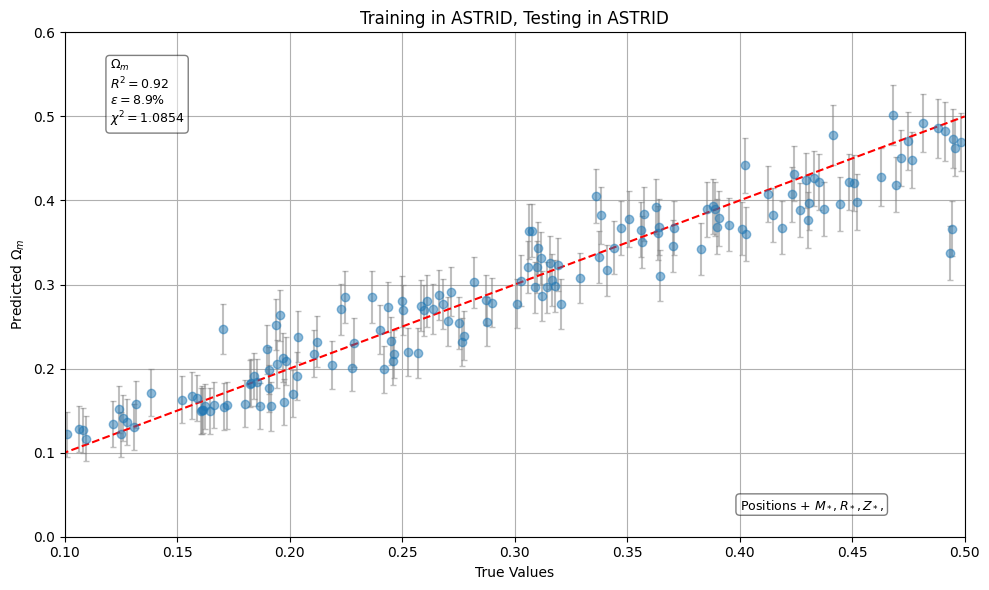

In [85]:
import matplotlib.pyplot as plt

# Evaluate model
test_means, test_stds, test_true, r2, epsilon, test_mse, chi_square = evaluate_model(trained_model, test_loader, device)
r2 = 0.92
epsilon = 0.0892

print(f'Test MSE: {test_mse:.6f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(test_true, test_means, yerr=test_stds, fmt='o', alpha=0.5, ecolor='gray', capsize=2, label='Predictions with Uncertainty')
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='--', label='Perfect Prediction Line')  # Perfect prediction line

plt.xlabel('True Values')
plt.ylabel(r'Predicted $\Omega_m$')
plt.title('Training in ASTRID, Testing in ASTRID')

# Add textbox with metrics
textstr = '\n'.join((
    r'$\Omega_m$',
    r'$R^2=%.2f$' % (r2,),
    r'$\epsilon=%.1f\%%$' % (epsilon * 100,),
    r'$\chi^2=%.4f$' % (chi_square,)
))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

plt.text(0.75, 0.05, r'Positions + $M_*, R_*, Z_*$,', transform=plt.gca().transAxes,
         fontsize=9, verticalalignment='bottom', bbox=props)

plt.xlim(0.1, 0.5)
plt.ylim(0, 0.6)
plt.grid(True)
#plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
